Initial GeoDataFrame shape: (698223, 4)
Columns: ['image_name', 'max_value', 'alku_aika', 'geometry']
CRS: EPSG:3067
Number of clusters: 43539
Number of valid cluster polygons: 39669
Filtered cluster polygons: 39669

Summary Statistics:
             area_m2   perimeter_m  perimeter_to_area   compactness  \
count   39669.000000  39669.000000       39669.000000  39669.000000   
mean      155.909749     57.823517           3.072749      0.375623   
std      1140.171970     99.917454          64.289620      0.181712   
min         0.004729      6.934134           0.039349      0.000046   
25%        20.472892     30.467279           0.501071      0.235426   
50%        49.456667     42.544304           0.811328      0.378877   
75%       110.588951     57.743045           1.443970      0.520157   
max    142089.719076   8173.174159        7614.631190      0.897087   

        shape_index  aspect_ratio_capped  elongation_index     convexity  \
count  39669.000000         39669.000000      3

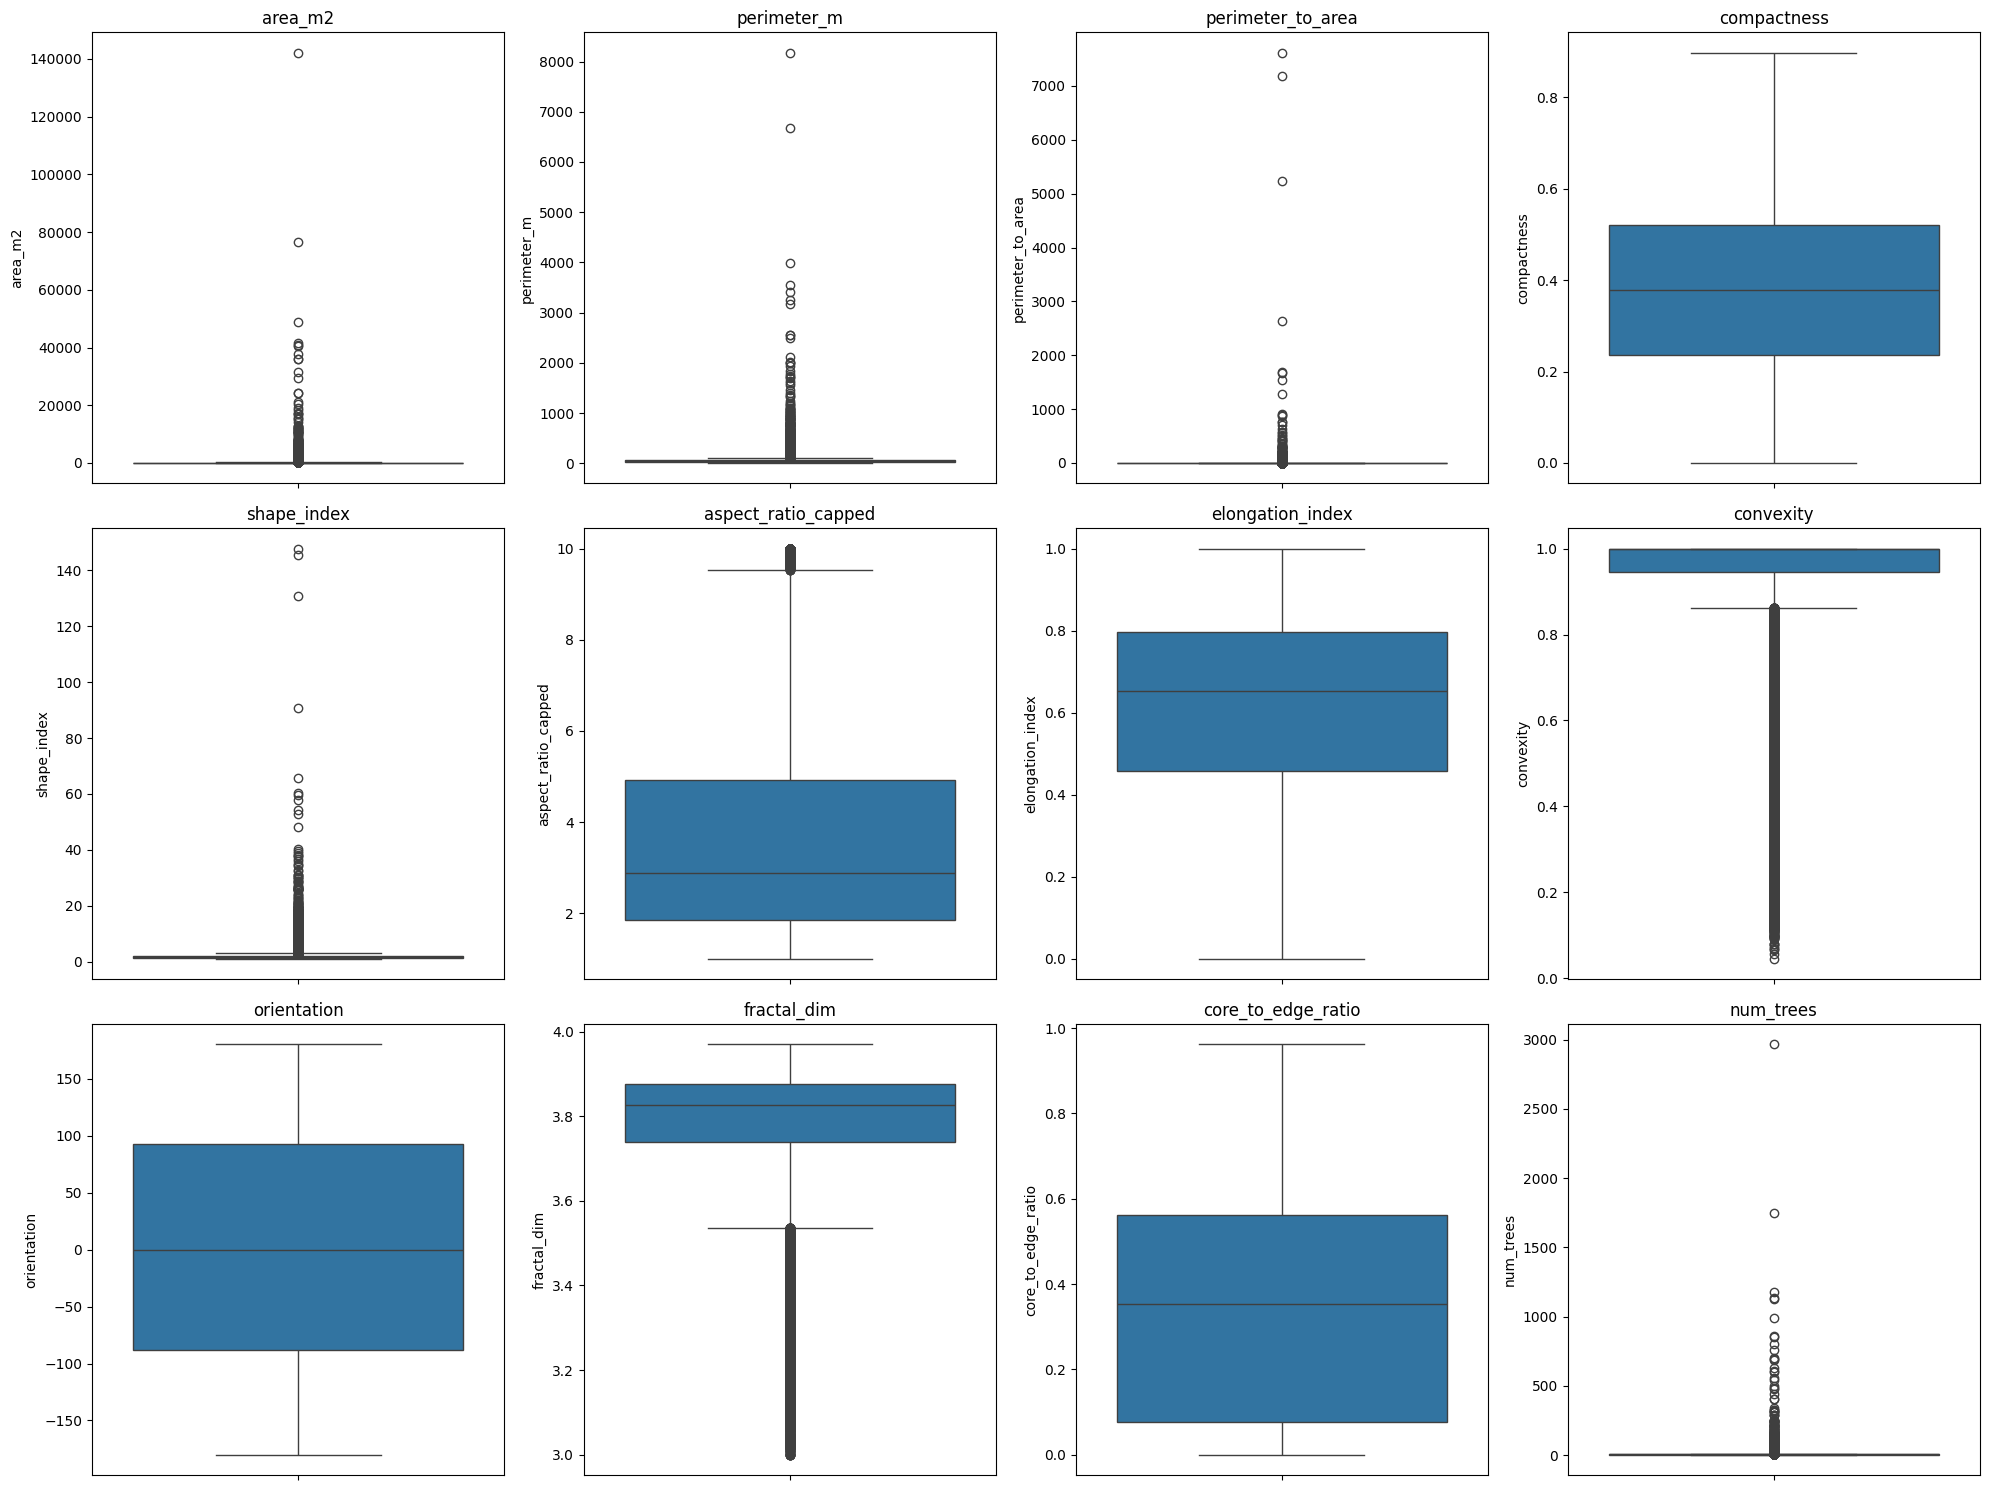

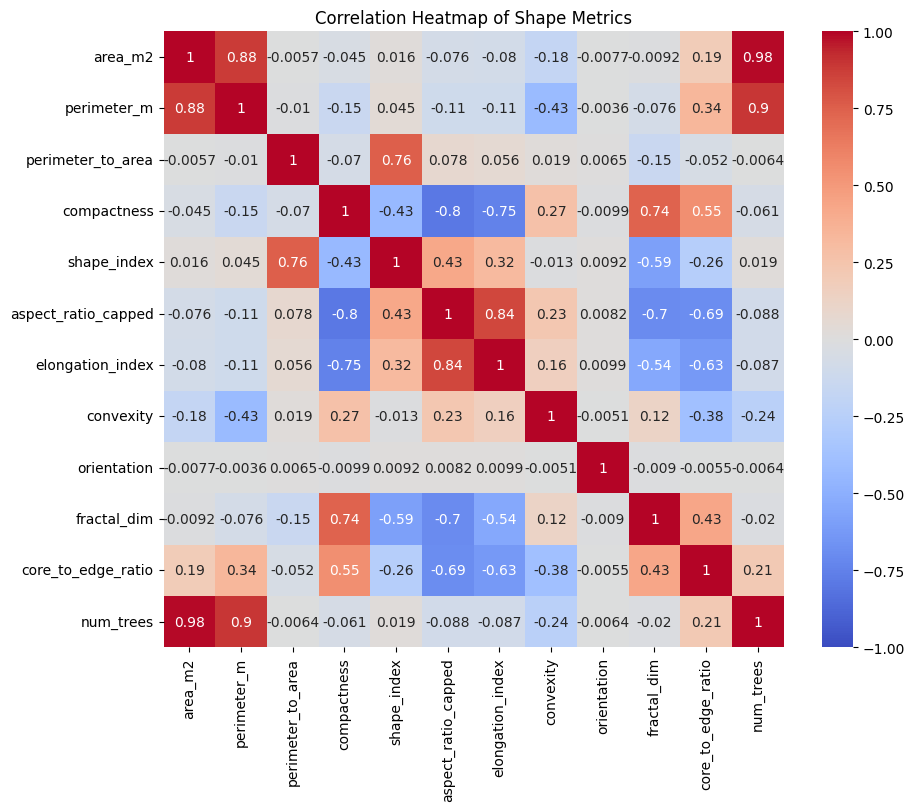

In [ ]:
import geopandas as gpd
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from shapely.geometry import MultiPoint, box
from scipy.stats import linregress
import matplotlib.pyplot as plt
import seaborn as sns
from alphashape import alphashape

# Step 1: Load the dead trees data
gpkg_file_path = "/Users/anisr/Documents/TreeClusters/data/DeadTrees_2023_Anis_ShapeStudy.gpkg"  # Replace with your actual file path
gdf = gpd.read_file(gpkg_file_path)
print("Initial GeoDataFrame shape:", gdf.shape)
print("Columns:", gdf.columns.tolist())
print("CRS:", gdf.crs)

# Step 2: Cluster the dead trees using DBSCAN
# Extract coordinates (x, y) for clustering
coords = np.array(list(zip(gdf.geometry.x, gdf.geometry.y)))

# Apply DBSCAN clustering
# eps: maximum distance between points in a cluster (in meters, adjust based on your data)
# min_samples: minimum number of points to form a cluster
db = DBSCAN(eps=20, min_samples=3).fit(coords)
gdf['cluster_label'] = db.labels_

# Remove noise points (labeled as -1 by DBSCAN)
gdf_clusters = gdf[gdf['cluster_label'] != -1].copy()
print("Number of clusters:", gdf_clusters['cluster_label'].nunique())

# Step 3: Create polygon geometries for each cluster using alpha shapes
def create_alpha_shape(points, alpha=0.1):
    """Create an alpha shape (concave hull) from a set of points."""
    if len(points) < 3:
        return None  # Need at least 3 points to form a polygon
    return alphashape(points, alpha)

# Group points by cluster and create alpha shapes
cluster_geometries = []
for cluster_id in gdf_clusters['cluster_label'].unique():
    cluster_points = gdf_clusters[gdf_clusters['cluster_label'] == cluster_id].geometry
    points = [(p.x, p.y) for p in cluster_points]
    alpha_shape = create_alpha_shape(points, alpha=0.1)  # Adjust alpha as needed
    if alpha_shape:
        cluster_geometries.append({'cluster_label': cluster_id, 'geometry': alpha_shape})

# Create a new GeoDataFrame for clusters
gdf_clusters_poly = gpd.GeoDataFrame(cluster_geometries, crs=gdf.crs)
print("Number of valid cluster polygons:", len(gdf_clusters_poly))

# Step 4: Compute enhanced shape metrics
# Basic metrics
gdf_clusters_poly['area_m2'] = gdf_clusters_poly.geometry.area
gdf_clusters_poly['perimeter_m'] = gdf_clusters_poly.geometry.length
gdf_clusters_poly['perimeter_to_area'] = gdf_clusters_poly['perimeter_m'] / gdf_clusters_poly['area_m2']
gdf_clusters_poly['compactness'] = (4 * np.pi * gdf_clusters_poly['area_m2']) / (gdf_clusters_poly['perimeter_m'] ** 2)
gdf_clusters_poly['shape_index'] = gdf_clusters_poly['perimeter_m'] / (2 * np.sqrt(np.pi * gdf_clusters_poly['area_m2']))

# Aspect ratio and elongation index
def compute_aspect_ratio_and_elongation(geom):
    min_rect = geom.minimum_rotated_rectangle
    coords = list(min_rect.exterior.coords)
    # Calculate lengths of sides
    side1 = np.sqrt((coords[1][0] - coords[0][0])**2 + (coords[1][1] - coords[0][1])**2)
    side2 = np.sqrt((coords[2][0] - coords[1][0])**2 + (coords[2][1] - coords[1][1])**2)
    length = max(side1, side2)
    width = min(side1, side2)
    aspect_ratio = length / width if width > 0 else np.nan
    elongation = 1 - (width / length) if length > 0 else np.nan
    return aspect_ratio, elongation

gdf_clusters_poly[['aspect_ratio', 'elongation_index']] = gdf_clusters_poly.geometry.apply(
    lambda x: pd.Series(compute_aspect_ratio_and_elongation(x))
)

# Cap aspect ratio to handle extreme values
gdf_clusters_poly['aspect_ratio_capped'] = gdf_clusters_poly['aspect_ratio'].clip(upper=10)

# Convexity
gdf_clusters_poly['convex_hull'] = gdf_clusters_poly.geometry.convex_hull
gdf_clusters_poly['convexity'] = gdf_clusters_poly.geometry.area / gdf_clusters_poly['convex_hull'].area

# Orientation (in degrees)
def compute_orientation(geom):
    min_rect = geom.minimum_rotated_rectangle
    coords = list(min_rect.exterior.coords)
    dx = coords[1][0] - coords[0][0]
    dy = coords[1][1] - coords[0][1]
    angle = np.arctan2(dy, dx) * 180 / np.pi  # Convert radians to degrees
    return angle

gdf_clusters_poly['orientation'] = gdf_clusters_poly.geometry.apply(compute_orientation)

# Fractal dimension (simplified box-counting method)
def fractal_dimension(geom, scales):
    if geom.is_empty:
        return np.nan
    counts = []
    for scale in scales:
        # Create a grid of boxes at the given scale
        bounds = geom.bounds
        x_min, y_min, x_max, y_max = bounds
        box_size = (x_max - x_min) * scale
        if box_size <= 0:
            continue
        x_bins = np.arange(x_min, x_max + box_size, box_size)
        y_bins = np.arange(y_min, y_max + box_size, box_size)
        count = 0
        for i in range(len(x_bins) - 1):
            for j in range(len(y_bins) - 1):
                box_poly = box(x_bins[i], y_bins[j], x_bins[i+1], y_bins[j+1])
                if geom.intersects(box_poly):
                    count += 1
        counts.append(count)
    scales = scales[:len(counts)]  # Match lengths
    if len(counts) < 2:
        return np.nan
    slope, _, _, _, _ = linregress(np.log(scales), np.log(counts))
    return 2 - slope  # Fractal dimension for 2D shapes

scales = np.logspace(-2, -1, 5)  # Adjust scales based on your data resolution
gdf_clusters_poly['fractal_dim'] = gdf_clusters_poly.geometry.apply(lambda x: fractal_dimension(x, scales))

# Core-to-edge ratio
buffer_distance = -1  # Inward buffer distance in meters, adjust as needed
gdf_clusters_poly['core_area'] = gdf_clusters_poly.geometry.buffer(buffer_distance).area
gdf_clusters_poly['core_area'] = gdf_clusters_poly['core_area'].clip(lower=0)  # Ensure non-negative
gdf_clusters_poly['core_to_edge_ratio'] = gdf_clusters_poly['core_area'] / gdf_clusters_poly['area_m2']

# Step 5: Add number of trees per cluster
cluster_tree_counts = gdf_clusters.groupby('cluster_label').size().to_dict()
gdf_clusters_poly['num_trees'] = gdf_clusters_poly['cluster_label'].map(cluster_tree_counts)

# Filter out invalid clusters (e.g., zero area, missing metrics)
gdf_clusters_poly = gdf_clusters_poly[
    (gdf_clusters_poly['area_m2'] > 0) &
    (gdf_clusters_poly['perimeter_m'] > 0) &
    (gdf_clusters_poly['core_to_edge_ratio'].notna()) &
    (gdf_clusters_poly['fractal_dim'].notna())
]
print("Filtered cluster polygons:", len(gdf_clusters_poly))

In [4]:
# Corrected fractal method

import numpy as np
from scipy.stats import linregress
from shapely.geometry import box as shapely_box

def fractal_dimension(geom, min_scale=0.1, max_scale=10, num_scales=10):
    """Calculate fractal dimension of a geometry using the box-counting method."""
    if geom.is_empty:
        return np.nan
    
    # Define scales logarithmically
    scales = np.logspace(np.log10(min_scale), np.log10(max_scale), num_scales)
    counts = []
    
    # Get bounding box of the geometry
    x_min, y_min, x_max, y_max = geom.bounds
    
    # Count boxes intersecting the geometry at each scale
    for scale in scales:
        box_size = scale
        x_bins = np.arange(x_min, x_max + box_size, box_size)
        y_bins = np.arange(y_min, y_max + box_size, box_size)
        count = 0
        for i in range(len(x_bins) - 1):
            for j in range(len(y_bins) - 1):
                box_poly = shapely_box(x_bins[i], y_bins[j], x_bins[i+1], y_bins[j+1])
                if geom.intersects(box_poly):
                    count += 1
        counts.append(count)
    
    # Filter out zero counts to avoid log(0)
    valid = np.array(counts) > 0
    scales = scales[valid]
    counts = np.array(counts)[valid]
    
    # Need at least 2 points for regression
    if len(counts) < 2:
        return np.nan
    
    # Calculate fractal dimension as the negative slope of log(scales) vs log(counts)
    slope, _, _, _, _ = linregress(np.log(scales), np.log(counts))
    return -slope

# Example usage with a GeoDataFrame of cluster polygons
min_scale = 0.1  # Smallest scale (e.g., 0.1 meters)
max_scale = 100  # Largest scale (e.g., 100 meters)
num_scales = 10  # Number of scales for smooth regression
gdf_clusters_poly['fractal_dim'] = gdf_clusters_poly.geometry.apply(
    lambda x: fractal_dimension(x, min_scale, max_scale, num_scales)
)

### Save to and Load from file

In [ ]:
output_file_path = "output/clusters_poly.gpkg"

# Convert 'convex_hull' to WKT and store in a new column
gdf_clusters_poly['convex_hull_wkt'] = gdf_clusters_poly['convex_hull'].apply(lambda x: x.wkt)

# Drop the original 'convex_hull' geometry column
gdf_clusters_poly = gdf_clusters_poly.drop(columns=['convex_hull'])
print(gdf_clusters_poly.dtypes)

gdf_clusters_poly.to_file(output_file_path, driver="GPKG")

cluster_label             int64
geometry               geometry
area_m2                 float64
perimeter_m             float64
perimeter_to_area       float64
compactness             float64
shape_index             float64
aspect_ratio            float64
elongation_index        float64
aspect_ratio_capped     float64
convexity               float64
orientation             float64
fractal_dim             float64
core_area               float64
core_to_edge_ratio      float64
num_trees                 int64
convex_hull_wkt          object
dtype: object


In [11]:
import geopandas as gpd
from shapely.wkt import loads

# Load the GeoDataFrame from disk
gdf_loaded = gpd.read_file(output_file_path)

# Convert WKT strings back to geometry objects
gdf_loaded['convex_hull'] = gdf_loaded['convex_hull_wkt'].apply(lambda x: loads(x))

# (Optional) Drop the WKT column
gdf_loaded = gdf_loaded.drop(columns=['convex_hull_wkt'])

# Verify the restored geometry
print(gdf_loaded[['geometry', 'convex_hull']].head())

                                            geometry  \
0  MULTIPOLYGON (((248504.906 6743918.138, 248521...   
1  MULTIPOLYGON (((248995.26 6743760.648, 248985....   
2  MULTIPOLYGON (((249948.361 6743410.796, 249947...   
3  MULTIPOLYGON (((249885.489 6743485.367, 249879...   
4  MULTIPOLYGON (((249861.597 6743522.789, 249826...   

                                         convex_hull  
0  POLYGON ((248511.98072139305 6743905.088930348...  
1  POLYGON ((248985.36542145596 6743760.549329502...  
2  POLYGON ((249948.36079545456 6743410.796401516...  
3  POLYGON ((249879.10453216376 6743476.823830409...  
4  POLYGON ((249861.59722222222 6743522.789141414...  


### Summary Statistics


Summary Statistics:
             area_m2   perimeter_m  perimeter_to_area   compactness  \
count   39669.000000  39669.000000       39669.000000  39669.000000   
mean      155.909749     57.823517           3.072749      0.375623   
std      1140.171970     99.917454          64.289620      0.181712   
min         0.004729      6.934134           0.039349      0.000046   
25%        20.472892     30.467279           0.501071      0.235426   
50%        49.456667     42.544304           0.811328      0.378877   
75%       110.588951     57.743045           1.443970      0.520157   
max    142089.719076   8173.174159        7614.631190      0.897087   

        shape_index  aspect_ratio_capped  elongation_index     convexity  \
count  39669.000000         39669.000000      39669.000000  39669.000000   
mean       2.029214             3.892903          0.609749      0.902776   
std        2.206399             2.770930          0.246787      0.201535   
min        1.055803             1.0

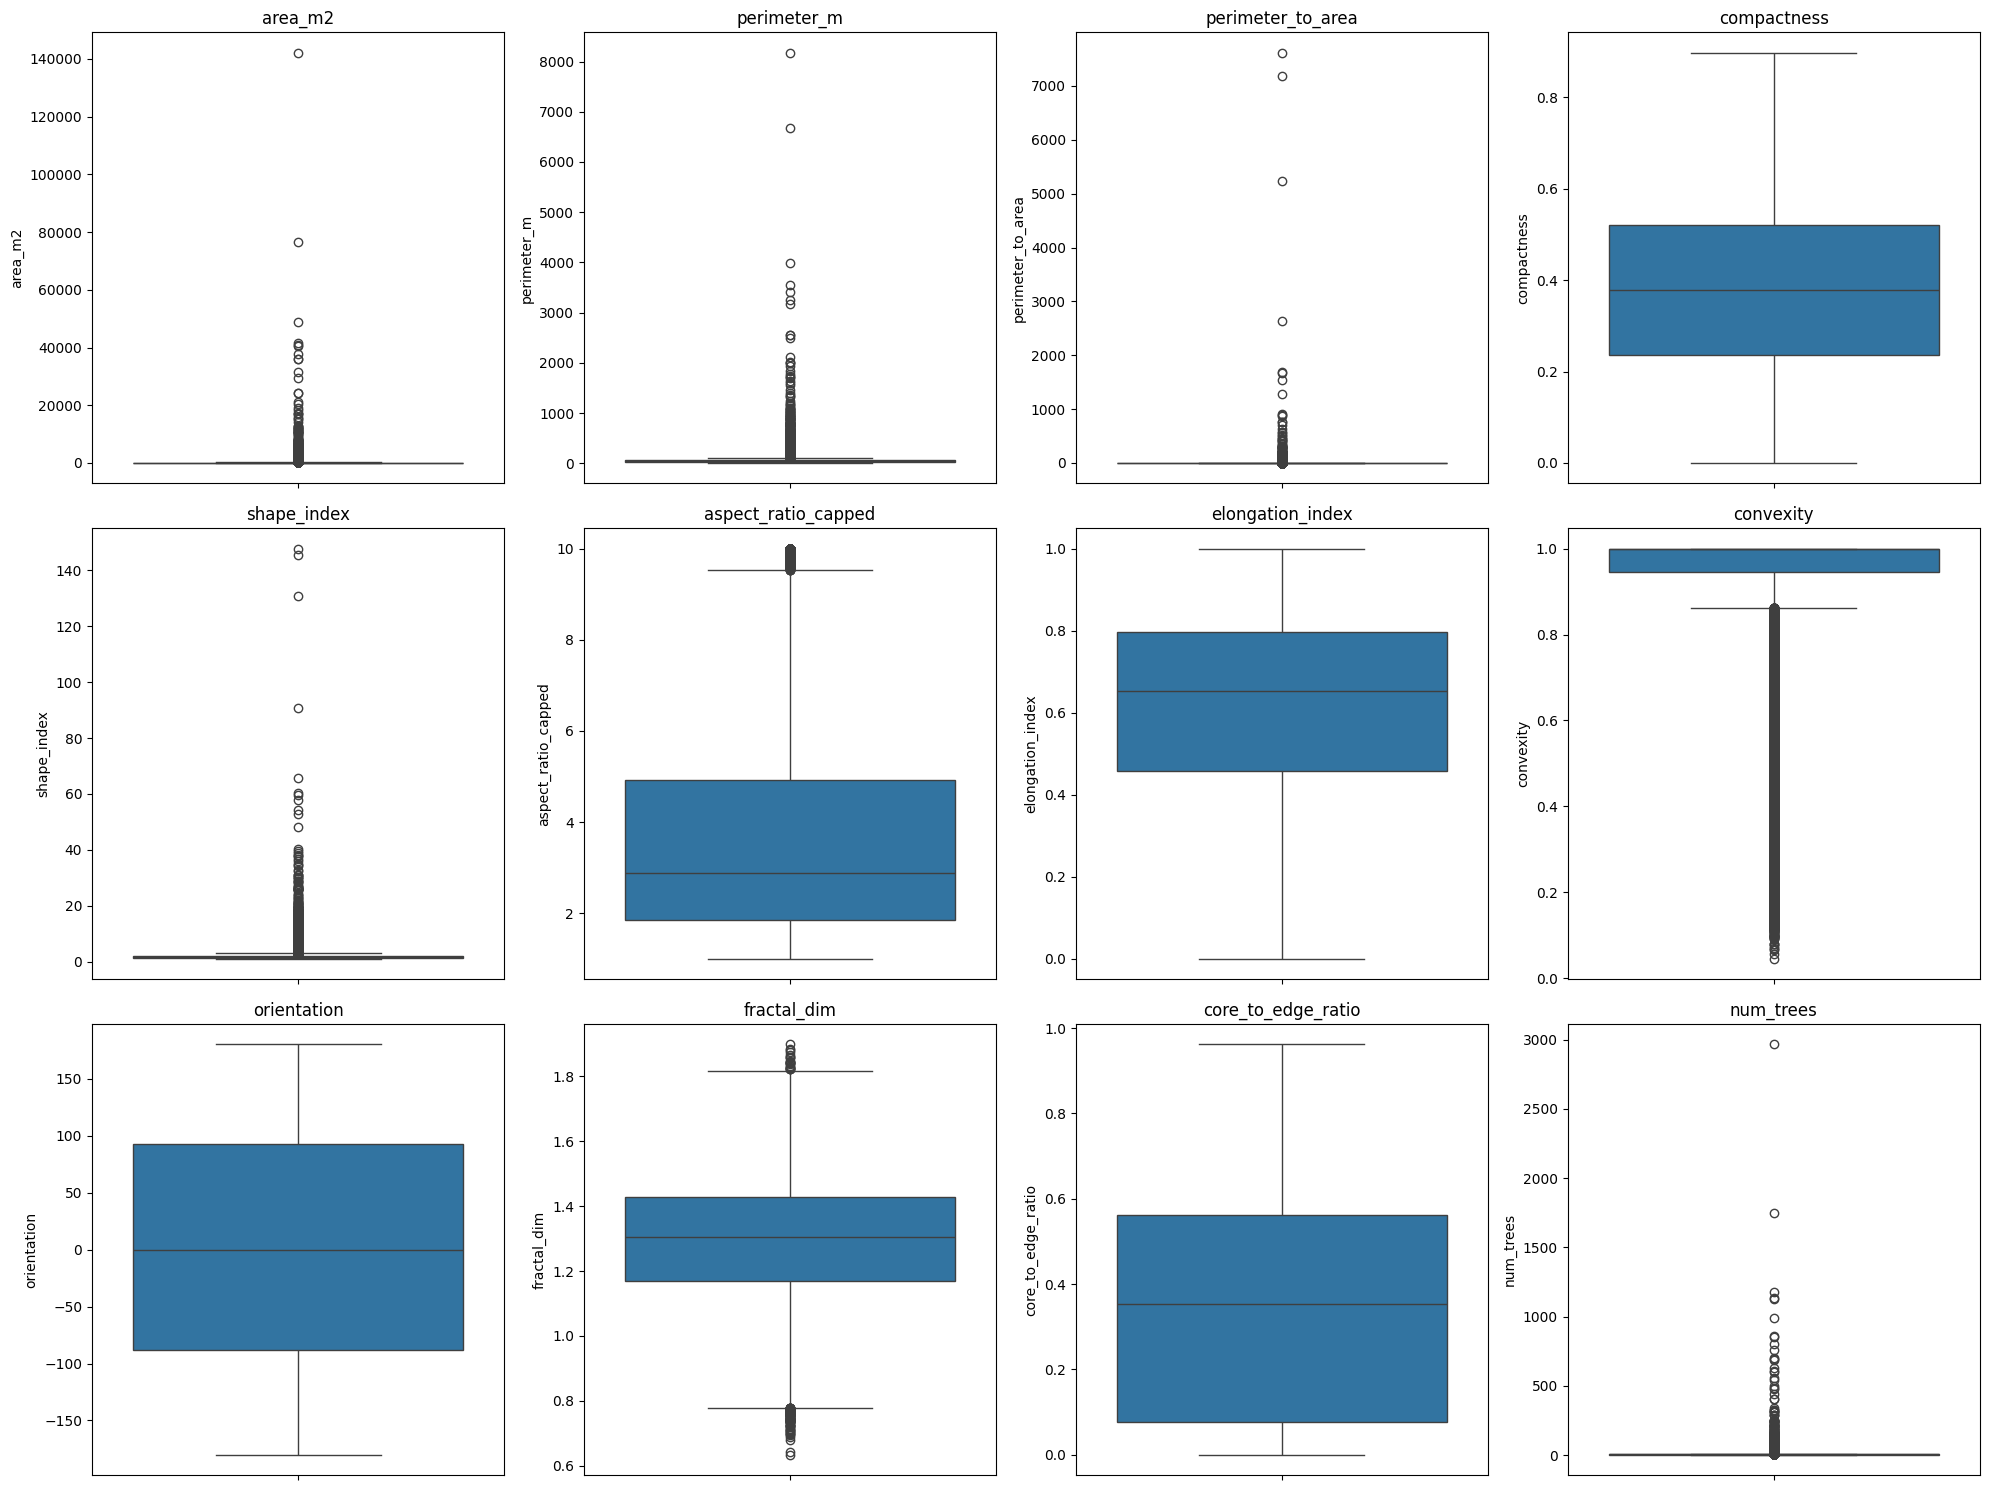

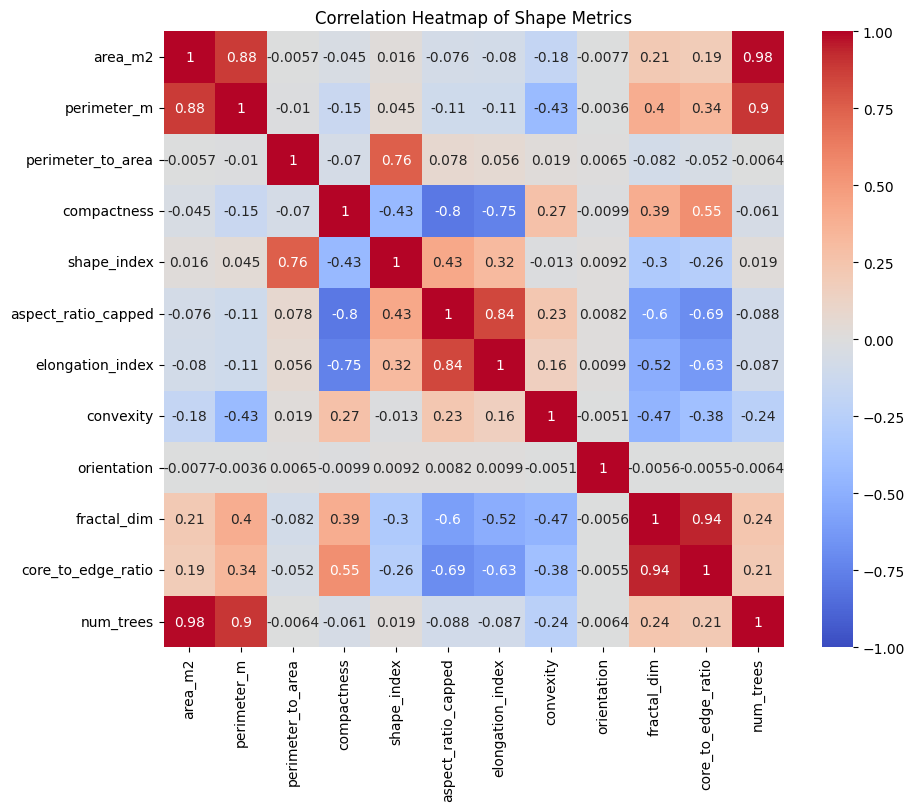

In [12]:
# Step 6: Summarize and visualize the metrics
# Summary statistics
metrics = [
    'area_m2', 'perimeter_m', 'perimeter_to_area', 'compactness', 'shape_index',
    'aspect_ratio_capped', 'elongation_index', 'convexity', 'orientation',
    'fractal_dim', 'core_to_edge_ratio', 'num_trees'
]
print("\nSummary Statistics:")
print(gdf_clusters_poly[metrics].describe())

# Visualization: Box plots for key metrics
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.flatten()
for i, metric in enumerate(metrics):
    sns.boxplot(y=metric, data=gdf_clusters_poly, ax=axes[i])
    axes[i].set_title(metric)
plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(gdf_clusters_poly[metrics].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Heatmap of Shape Metrics")
plt.show()

### Reduce Metric Redundancy

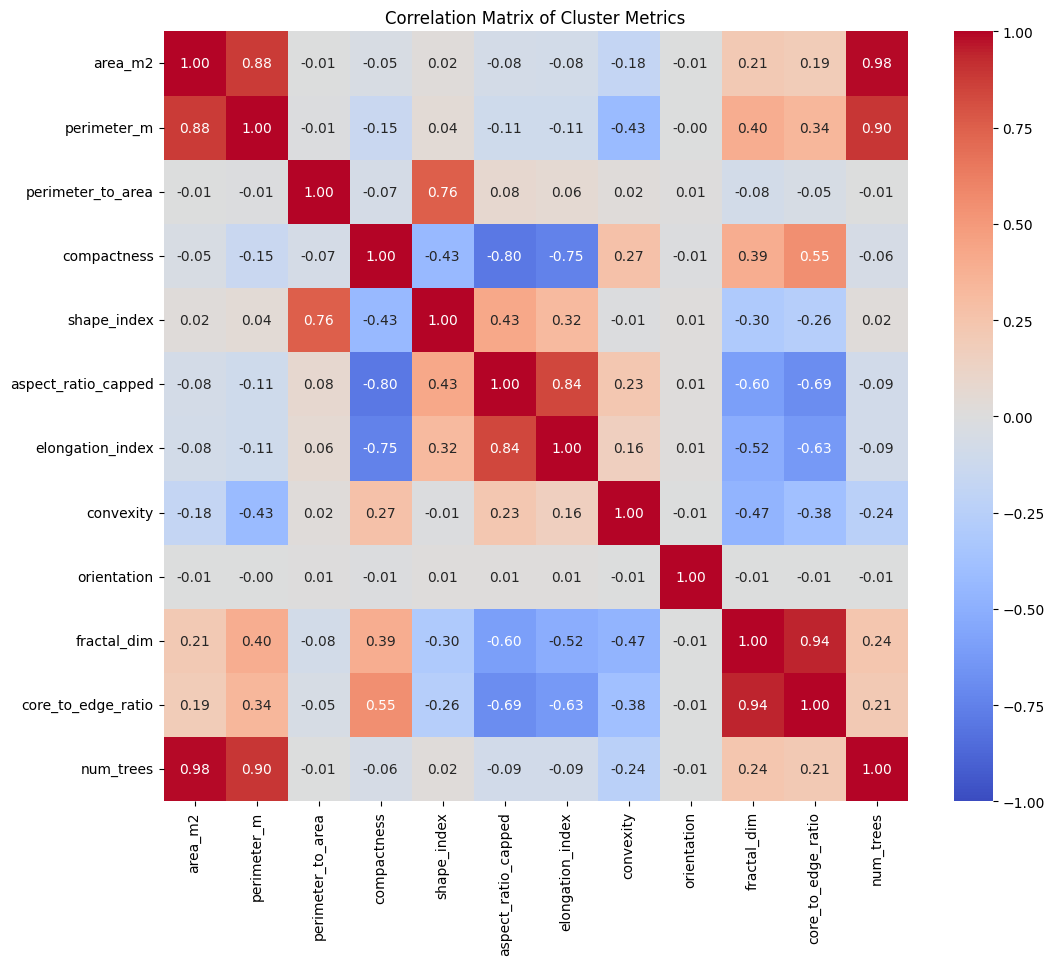

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your data is in a GeoDataFrame called gdf_clusters_poly
metrics = [
    'area_m2', 'perimeter_m', 'perimeter_to_area', 'compactness', 'shape_index',
    'aspect_ratio_capped', 'elongation_index', 'convexity', 'orientation',
    'fractal_dim', 'core_to_edge_ratio', 'num_trees'
]

# Calculate the correlation matrix
corr_matrix = gdf_clusters_poly[metrics].corr()

# Visualize it with a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
plt.title('Correlation Matrix of Cluster Metrics')
plt.show()

In [16]:
# Define the metrics to keep
metrics_to_keep = [
    'area_m2', 'perimeter_to_area', 'compactness', 'shape_index',
    'aspect_ratio_capped', 'convexity', 'orientation', 'fractal_dim'
]

# Create a reduced GeoDataFrame, including 'geometry' and 'cluster_label' if needed
gdf_reduced = gdf_clusters_poly[metrics_to_keep + ['geometry', 'cluster_label']]

### Refine Clustering

In [17]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Assuming your data is in a GeoDataFrame called gdf_reduced
metrics = ['area_m2', 'perimeter_to_area', 'compactness', 'shape_index',
           'aspect_ratio_capped', 'convexity', 'orientation', 'fractal_dim']

# Extract the metrics
data = gdf_reduced[metrics]

# Check for missing values
print(data.isnull().sum())

# Handle missing values (e.g., drop rows with NaNs)
data = data.dropna()

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
data_scaled = pd.DataFrame(data_scaled, columns=metrics)

area_m2                0
perimeter_to_area      0
compactness            0
shape_index            0
aspect_ratio_capped    0
convexity              0
orientation            0
fractal_dim            0
dtype: int64


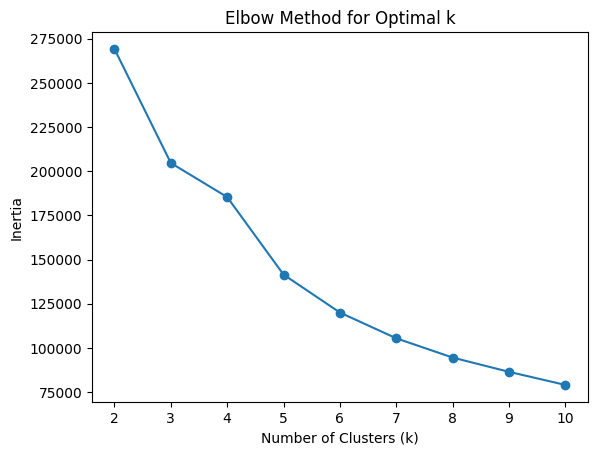

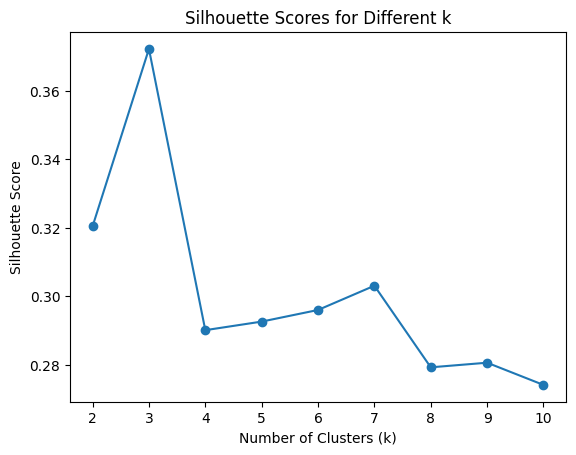

In [18]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Elbow Method
inertia = []
k_range = range(2, 11)  # Test k from 2 to 10
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

# Silhouette Scores
silhouette_scores = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(data_scaled)
    score = silhouette_score(data_scaled, labels)
    silhouette_scores.append(score)

plt.plot(k_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different k')
plt.show()

In [19]:
# Set the optimal number of clusters (replace 3 with your chosen k)
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
gdf_reduced['cluster_label'] = kmeans.fit_predict(data_scaled)

/Users/anisr/Documents/TreeClusters/venv/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


                  area_m2  perimeter_to_area  compactness  shape_index  \
cluster_label                                                            
0              654.099724           0.539647     0.256900     2.099185   
1               84.446809           0.808575     0.488063     1.466021   
2               18.612002          10.680511     0.157443     3.464569   

               aspect_ratio_capped  convexity  orientation  fractal_dim  
cluster_label                                                            
0                         2.569920   0.469396     2.404971     1.500263  
1                         2.557886   0.974504    -0.067584     1.319985  
2                         8.267270   0.997068     2.299301     1.101845  


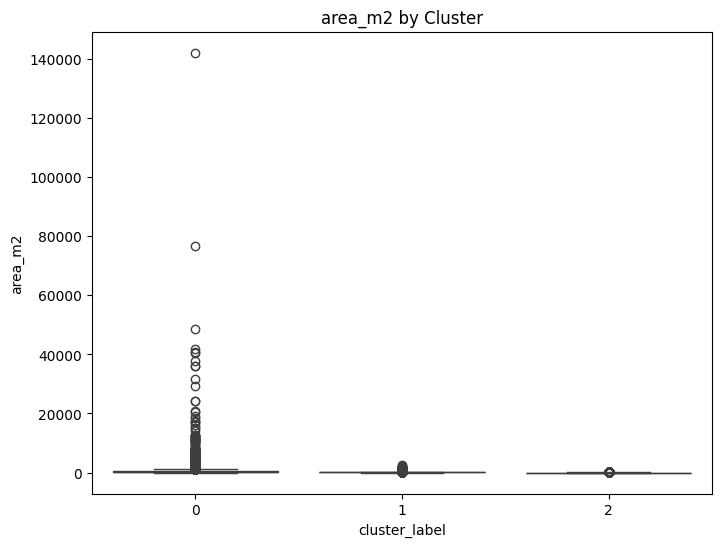

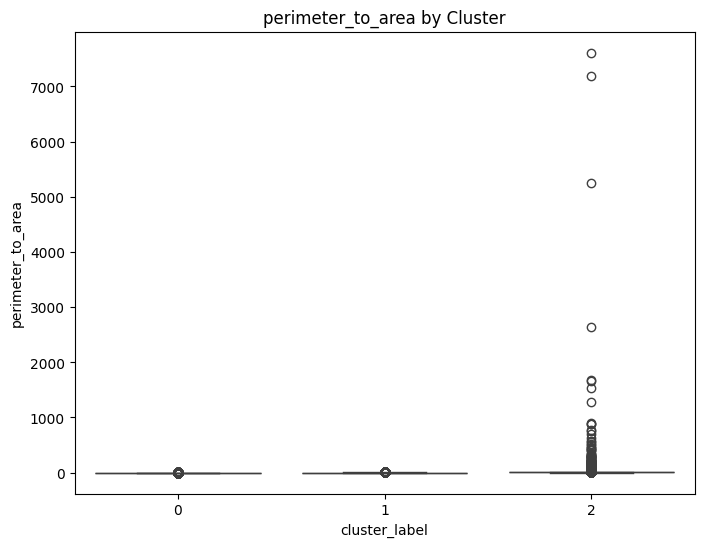

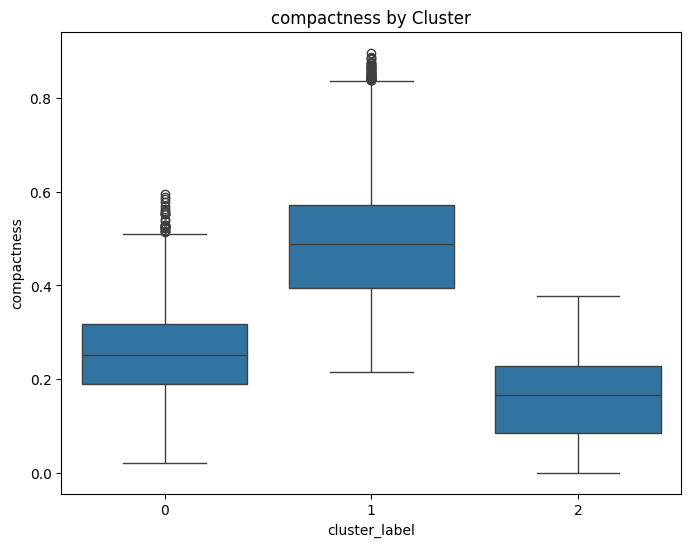

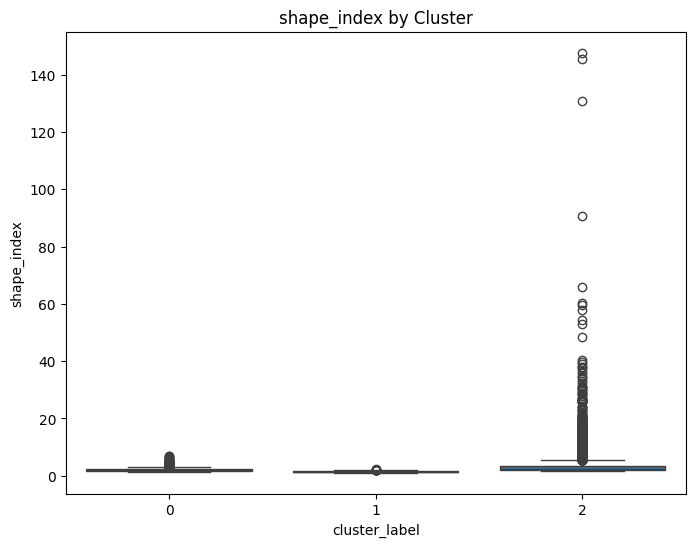

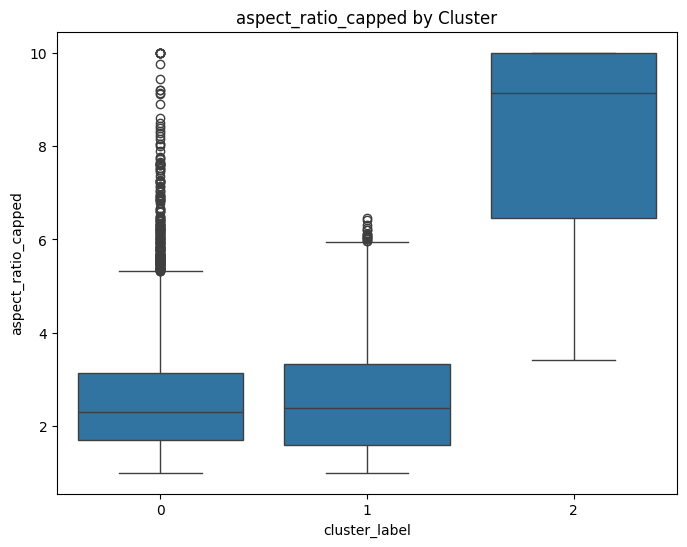

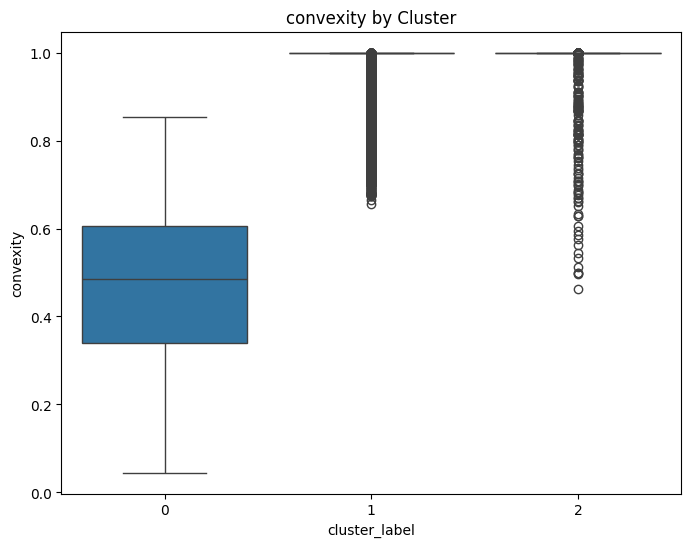

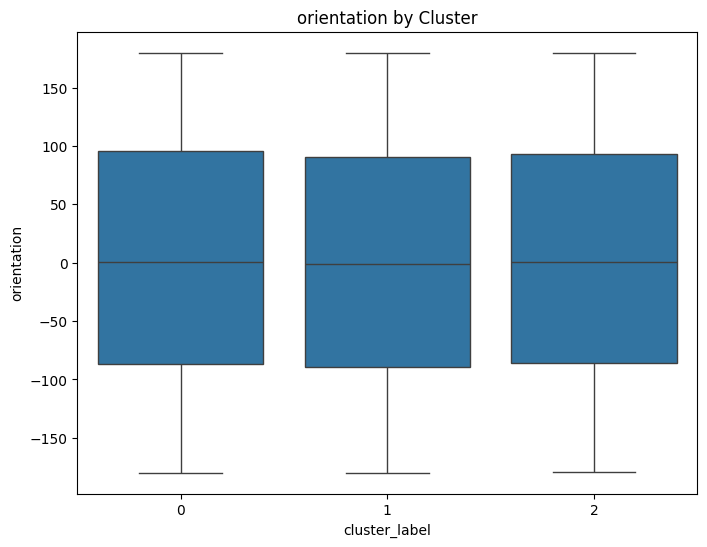

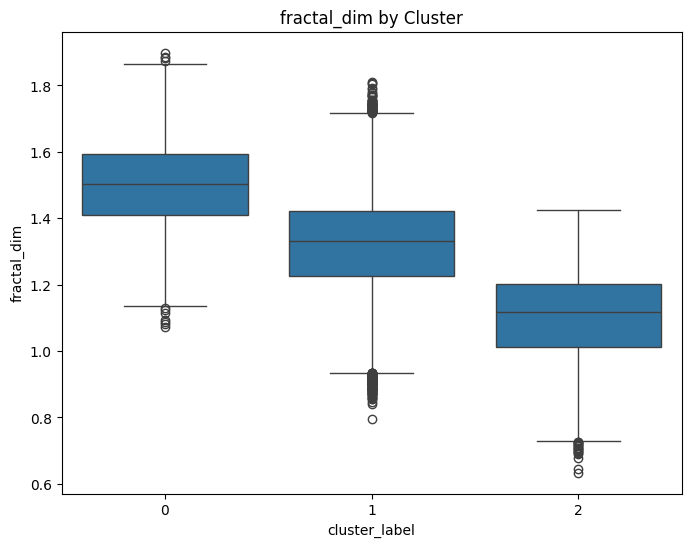

In [20]:
# Calculate mean values per cluster
cluster_means = gdf_reduced.groupby('cluster_label')[metrics].mean()
print(cluster_means)

# Visualize with box plots
import seaborn as sns
for metric in metrics:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='cluster_label', y=metric, data=gdf_reduced)
    plt.title(f'{metric} by Cluster')
    plt.show()

In [21]:
from sklearn.metrics import davies_bouldin_score

# Silhouette Score
sil_score = silhouette_score(data_scaled, gdf_reduced['cluster_label'])
print(f'Silhouette Score: {sil_score:.3f}')

# Davies-Bouldin Index
db_index = davies_bouldin_score(data_scaled, gdf_reduced['cluster_label'])
print(f'Davies-Bouldin Index: {db_index:.3f}')

Silhouette Score: 0.372
Davies-Bouldin Index: 1.060


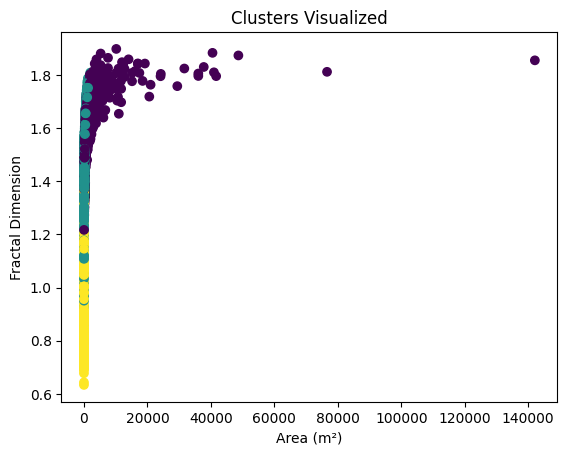

In [22]:
plt.scatter(gdf_reduced['area_m2'], gdf_reduced['fractal_dim'], c=gdf_reduced['cluster_label'], cmap='viridis')
plt.xlabel('Area (m²)')
plt.ylabel('Fractal Dimension')
plt.title('Clusters Visualized')
plt.show()

In [23]:
gdf_reduced.shape

(39669, 10)

In [ ]:
# Load Dead Tree Location Data

# Import required libraries
import geopandas as gpd
import pandas as pd

# Specify the path to your GeoPackage file
gpkg_file_path = "/Users/anisr/Documents/TreeClusters/data/DeadTrees_2023_Anis_ShapeStudy.gpkg"  # Replace with your actual file path

# Read the GeoPackage file into a GeoDataFrame
gdf = gpd.read_file(gpkg_file_path)

# Display the first few rows to check the data
print("First 5 rows of the GeoDataFrame:")
print(gdf.head())

# Check the column names and data types
print("\nColumn names and data types:")
print(gdf.dtypes)

# Extract coordinates into a pandas DataFrame (if needed)
# Assuming the geometry column contains Point geometries with x, y coordinates
if 'geometry' in gdf.columns:
    # Extract x and y coordinates from the geometry column
    gdf['x'] = gdf['geometry'].x
    gdf['y'] = gdf['geometry'].y
    
    # Create a pandas DataFrame with just the coordinates and any other relevant columns
    df = pd.DataFrame(gdf[['x', 'y']].copy())  # Add other columns if present, e.g., cluster_id
    
    # Display the first few rows of the pandas DataFrame
    print("\nFirst 5 rows of the pandas DataFrame with coordinates:")
    print(df.head())
else:
    print("No 'geometry' column found in the GeoPackage file.")

First 5 rows of the GeoDataFrame:
               image_name  max_value           alku_aika  \
0  L3423E_2023_RGBNIR.tif   0.021545  14.6.2023 08.10.00   
1  L3423E_2023_RGBNIR.tif   0.225118  14.6.2023 08.10.00   
2  L3423E_2023_RGBNIR.tif   0.356665  14.6.2023 08.10.00   
3  L3423E_2023_RGBNIR.tif  -0.102582  14.6.2023 08.10.00   
4  L3423E_2023_RGBNIR.tif   0.485687  14.6.2023 08.10.00   

                         geometry  
0  POINT (248450.873 6743402.657)  
1   POINT (248223.78 6743430.848)  
2  POINT (248222.085 6743441.503)  
3  POINT (248461.938 6743465.468)  
4  POINT (248358.675 6743492.817)  

Column names and data types:
image_name      object
max_value      float64
alku_aika       object
geometry      geometry
dtype: object

First 5 rows of the pandas DataFrame with coordinates:
               x             y
0  248450.872863  6.743403e+06
1  248223.780303  6.743431e+06
2  248222.085145  6.743442e+06
3  248461.938008  6.743465e+06
4  248358.674578  6.743493e+06


In [81]:
# Clustered Dead Tree Locations

# Import required libraries
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
import geopandas as gpd

# Assuming your DataFrame 'df' has 'x' and 'y' columns from the previous step
# If not, replace 'df' with your actual DataFrame name
# Example: df = pd.DataFrame({'x': [1, 2, 3, ...], 'y': [4, 5, 6, ...]})

# Extract coordinates as a numpy array for DBSCAN
coords = df[['x', 'y']].to_numpy()

# Define DBSCAN parameters
# eps = 20 meters (distance threshold), min_samples = 3 (minimum trees per cluster)
dbscan = DBSCAN(eps=20, min_samples=3, metric='euclidean')

# Fit and predict cluster labels
cluster_labels = dbscan.fit_predict(coords)

# Add cluster labels to the original DataFrame
# -1 indicates noise (trees not in any cluster)
df['cluster_id'] = cluster_labels

# Display basic clustering results
print("Number of clusters found:", len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0))
print("Number of noise points (not in clusters):", sum(cluster_labels == -1))
print("First 5 rows with cluster IDs:")
print(df.head())

# Optional: Filter out noise points and keep only valid clusters
df_clusters = df[df['cluster_id'] != -1].copy()
print("\nFirst 5 rows of DataFrame with valid clusters only:")
print(df_clusters.head())

# Optional: Save the clustered data back to a GeoDataFrame if needed
if 'geometry' in gdf.columns:  # Assuming 'gdf' is your original GeoDataFrame
    gdf['cluster_id'] = cluster_labels
    print("\nGeoDataFrame updated with cluster IDs:")
    print(gdf.head())
    # Save to a new GeoPackage file
    gdf.to_file("dead_trees_with_clusters.gpkg", driver="GPKG")
    print("Clustered data saved to 'dead_trees_with_clusters.gpkg'")

Number of clusters found: 43539
Number of noise points (not in clusters): 396752
First 5 rows with cluster IDs:
               x             y  cluster_id
0  248450.872863  6.743403e+06          -1
1  248223.780303  6.743431e+06          -1
2  248222.085145  6.743442e+06          -1
3  248461.938008  6.743465e+06          -1
4  248358.674578  6.743493e+06          -1

First 5 rows of DataFrame with valid clusters only:
                x             y  cluster_id
18  248511.980721  6.743905e+06           0
20  248524.691092  6.743909e+06           0
21  248521.576149  6.743909e+06           0
22  248504.905822  6.743918e+06           0
23  248494.608740  6.743932e+06           0

GeoDataFrame updated with cluster IDs:
               image_name  max_value           alku_aika  \
0  L3423E_2023_RGBNIR.tif   0.021545  14.6.2023 08.10.00   
1  L3423E_2023_RGBNIR.tif   0.225118  14.6.2023 08.10.00   
2  L3423E_2023_RGBNIR.tif   0.356665  14.6.2023 08.10.00   
3  L3423E_2023_RGBNIR.tif  -0.102

In [ ]:
# Cluster Shape Computation

# Import required libraries
import pandas as pd
import numpy as np
import geopandas as gpd
import alphashape
from shapely.geometry import Polygon, MultiPoint
from shapely.ops import unary_union
import warnings
warnings.filterwarnings("ignore", category=UserWarning)  # Suppress alphashape warnings

# Assuming 'df' is your DataFrame with 'x', 'y', and 'cluster_id' from the previous step
# Filter out noise points (-1) and get unique cluster IDs
valid_clusters = df[df['cluster_id'] != -1]['cluster_id'].unique()

# Initialize an empty list to store cluster metrics
cluster_metrics = []

# Define alpha value for concave hull (adjust as needed)
alpha = 0.5  # Smaller alpha = tighter boundary; tune based on your data

# Function to calculate minimum bounding rectangle properties
def get_mbr_properties(polygon):
    min_rect = polygon.minimum_rotated_rectangle
    coords = list(min_rect.exterior.coords)
    lengths = [np.sqrt((coords[i][0] - coords[i+1][0])**2 + (coords[i][1] - coords[i+1][1])**2) 
               for i in range(len(coords)-1)]
    length, width = sorted(lengths[:2], reverse=True)  # Longest and shortest sides

    min_width = 1.0  # Set a minimum width of 1 meters
    width = max(width, min_width)
    aspect_ratio = length / width if width > 0 else np.inf
    
    # Orientation: angle of longest side from horizontal (in degrees)
    dx = coords[1][0] - coords[0][0]
    dy = coords[1][1] - coords[0][1]
    orientation = np.degrees(np.arctan2(dy, dx)) % 180
    return aspect_ratio, orientation

# Loop through each cluster to compute shape metrics
for cluster_id in valid_clusters:
    # Extract coordinates for the current cluster
    cluster_points = df[df['cluster_id'] == cluster_id][['x', 'y']].to_numpy()
    
    # Skip if too few points to form a valid polygon
    if len(cluster_points) < 3:
        continue
    
    # Generate concave hull (alpha shape)
    alpha_shape = alphashape.alphashape(cluster_points, alpha)
    
    # Handle cases where alpha_shape might be a MultiPolygon or invalid
    if alpha_shape.is_empty or not alpha_shape.is_valid:
        continue
    if alpha_shape.geom_type == 'MultiPolygon':
        alpha_shape = unary_union(alpha_shape)  # Merge into a single Polygon
    
    # Convert to shapely Polygon if not already
    if alpha_shape.geom_type != 'Polygon':
        continue
    
    # Calculate shape metrics
    area = alpha_shape.area  # Area in square meters
    perimeter = alpha_shape.length  # Perimeter in meters
    compactness = 4 * np.pi * area / (perimeter ** 2) if perimeter > 0 else 0  # Shape regularity
    circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0  # Similar to compactness
    convex_hull = alpha_shape.convex_hull
    convexity = area / convex_hull.area if convex_hull.area > 0 else 0  # Ratio to convex hull
    aspect_ratio, orientation = get_mbr_properties(alpha_shape)  # From minimum bounding rectangle
    
    # Store metrics in a dictionary
    metrics = {
        'cluster_id': cluster_id,
        'area_m2': area,
        'perimeter_m': perimeter,
        'compactness': compactness,
        'circularity': circularity,
        'convexity': convexity,
        'aspect_ratio': aspect_ratio,
        'orientation_deg': orientation,
        'num_trees': len(cluster_points)  # Number of trees in the cluster
    }
    cluster_metrics.append(metrics)

# Create a DataFrame from the metrics and include x and y values
cluster_metrics_df = pd.DataFrame(cluster_metrics)

# Add x and y values for each cluster by calculating the mean of x and y coordinates for the cluster
cluster_metrics_df['x'] = cluster_metrics_df['cluster_id'].apply(
    lambda cid: df[df['cluster_id'] == cid]['x'].mean()
)
cluster_metrics_df['y'] = cluster_metrics_df['cluster_id'].apply(
    lambda cid: df[df['cluster_id'] == cid]['y'].mean()
)

# Display the first few rows
print("Cluster Shape Metrics DataFrame:")
print(cluster_metrics_df.head())

# Optional: Save to a CSV file
cluster_metrics_df.to_csv("cluster_shape_metrics.csv", index=False)
print("Metrics saved to 'cluster_shape_metrics.csv'")

# Optional: Add geometries to a GeoDataFrame for visualization
gdf_clusters = gpd.GeoDataFrame(
    cluster_metrics_df,
    geometry=[alphashape.alphashape(df[df['cluster_id'] == cid][['x', 'y']].to_numpy(), alpha)
              for cid in cluster_metrics_df['cluster_id']],
    crs=gdf.crs  # Use the CRS from your original GeoDataFrame
)
gdf_clusters.to_file("cluster_shapes.gpkg", driver="GPKG")
print("Cluster shapes saved to 'cluster_shapes.gpkg'")

Descriptive Statistics for Cluster Shape Metrics:
         cluster_id       area_m2   perimeter_m   compactness   circularity  \
count  18583.000000  18583.000000  18583.000000  18583.000000  18583.000000   
mean   21912.001076     37.620175     37.318389      0.313799      0.313799   
std    12706.847640     36.506813     14.882055      0.174447      0.174447   
min        2.000000      0.004729      6.934134      0.000046      0.000046   
25%    10946.000000     10.572418     25.692374      0.169320      0.169320   
50%    21930.000000     24.845094     37.412955      0.313817      0.313817   
75%    32870.000000     52.954359     47.981990      0.465256      0.465256   
max    43536.000000    195.842506     77.724515      0.719735      0.719735   

          convexity  aspect_ratio  orientation_deg     num_trees  
count  18583.000000  18583.000000     18583.000000  18583.000000  
mean       0.999996      6.770903        91.056219      3.658021  
std        0.000572      6.329937    

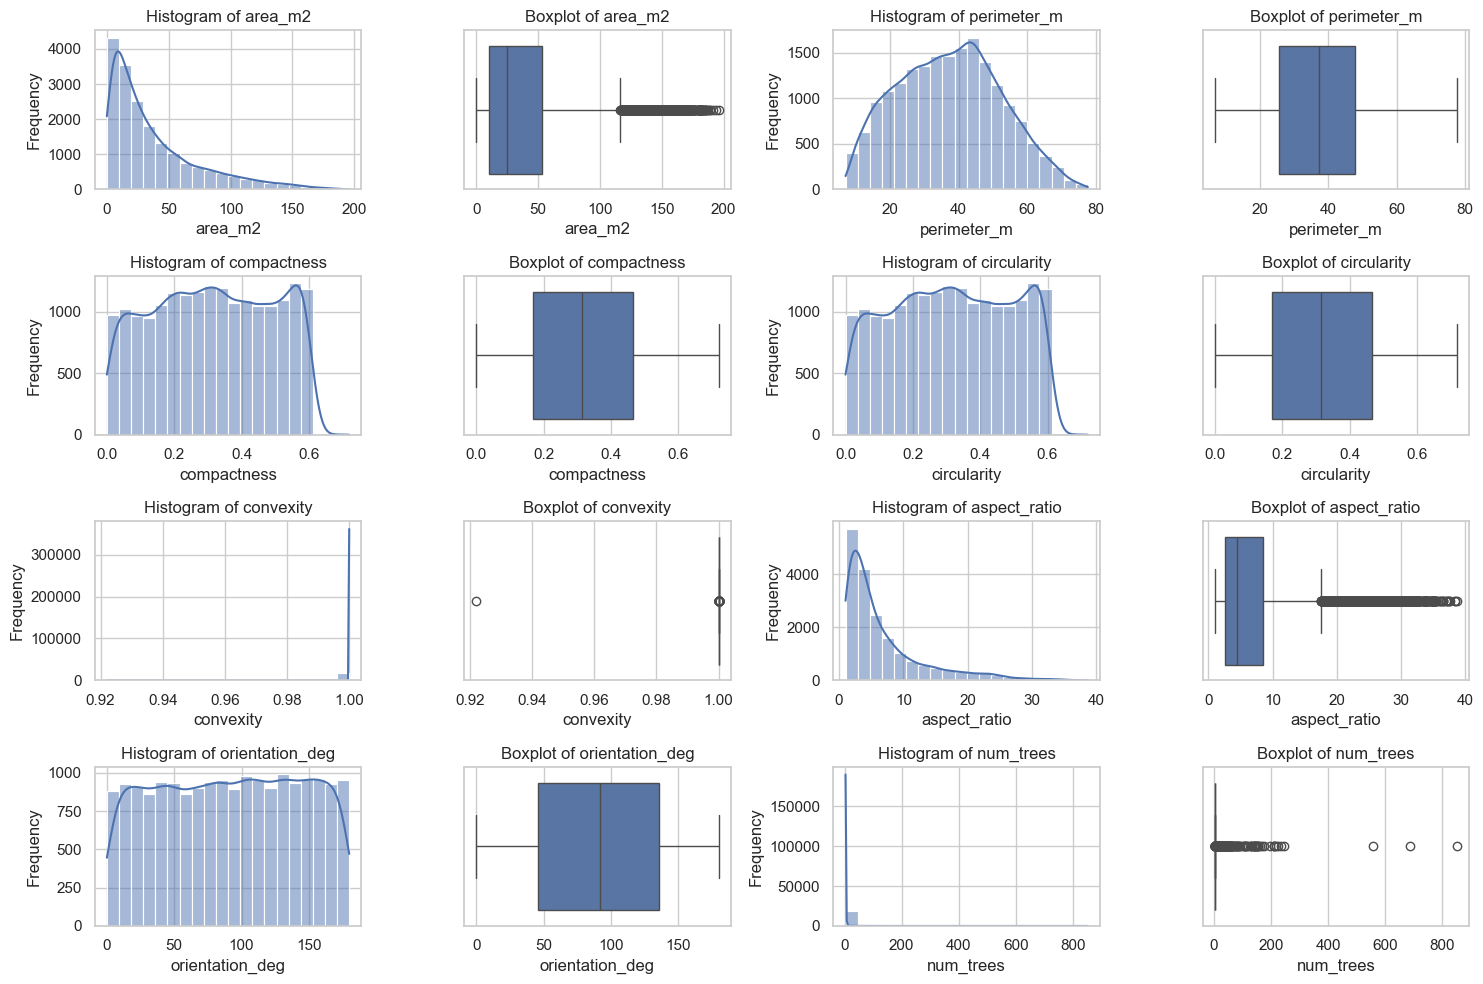

Descriptive statistics saved to 'cluster_metrics_descriptive_stats.csv'


In [14]:
# Descriptive Statistics and Distribution Analysis

# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'cluster_metrics_df' is your DataFrame from the previous step
# Example columns: 'cluster_id', 'area_m2', 'perimeter_m', 'compactness', 'circularity', 
# 'convexity', 'aspect_ratio', 'orientation_deg', 'num_trees'

# 1. Calculate Descriptive Statistics
print("Descriptive Statistics for Cluster Shape Metrics:")
desc_stats = cluster_metrics_df.describe()
print(desc_stats)

# Additional statistics: skewness and kurtosis
print("\nSkewness of Metrics:")
print(cluster_metrics_df.skew(numeric_only=True))
print("\nKurtosis of Metrics:")
print(cluster_metrics_df.kurtosis(numeric_only=True))

# 2. Visualize Distributions
# List of metrics to analyze
metrics = ['area_m2', 'perimeter_m', 'compactness', 'circularity', 'convexity', 
           'aspect_ratio', 'orientation_deg', 'num_trees']

# Set up the plotting style
sns.set(style="whitegrid")
plt.figure(figsize=(15, 10))

# Create histograms and boxplots for each metric
for i, metric in enumerate(metrics, 1):
    # Histogram
    plt.subplot(4, 4, 2*i-1)  # Left column: histograms
    sns.histplot(cluster_metrics_df[metric], bins=20, kde=True)
    plt.title(f'Histogram of {metric}')
    plt.xlabel(metric)
    plt.ylabel('Frequency')
    
    # Boxplot
    plt.subplot(4, 4, 2*i)  # Right column: boxplots
    sns.boxplot(x=cluster_metrics_df[metric])
    plt.title(f'Boxplot of {metric}')
    plt.xlabel(metric)

plt.tight_layout()
plt.show()

# Optional: Save descriptive statistics to a CSV
desc_stats.to_csv("cluster_metrics_descriptive_stats.csv")
print("Descriptive statistics saved to 'cluster_metrics_descriptive_stats.csv'")

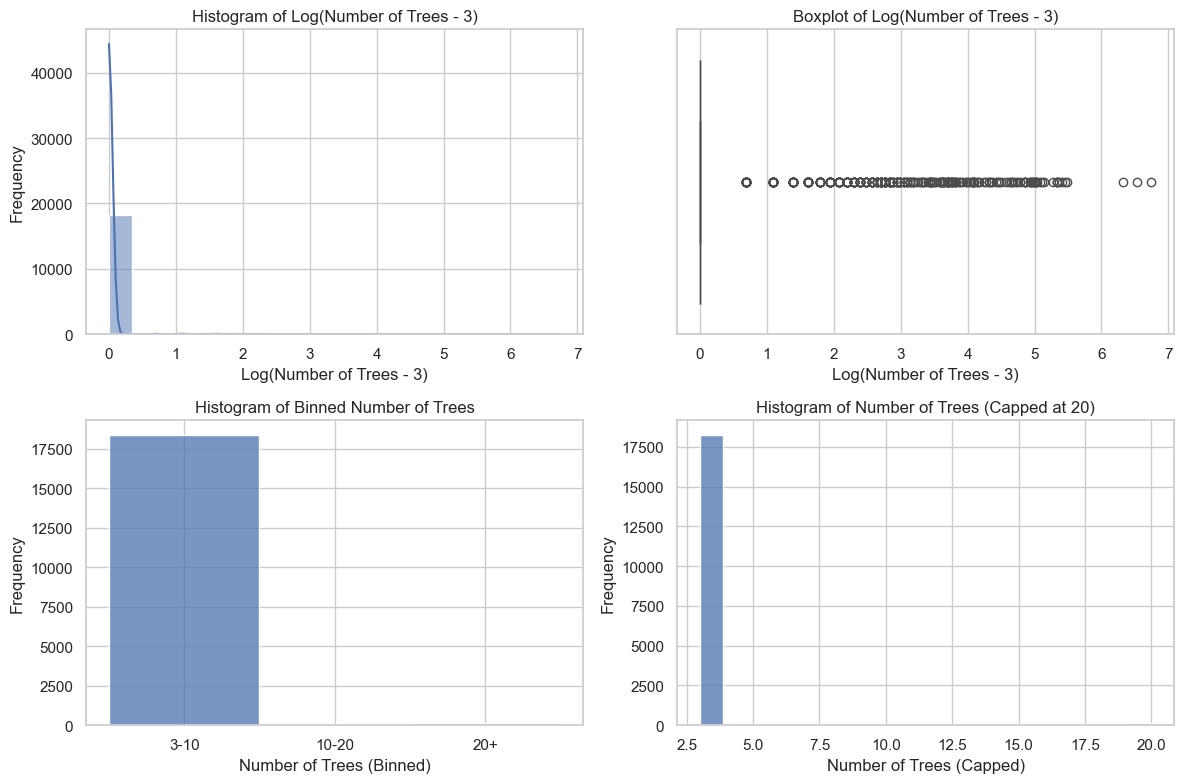

Percentiles for num_trees:
0.90     3.0
0.95     3.0
0.99    12.0
Name: num_trees, dtype: float64


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'cluster_metrics_df' is your DataFrame
# Focus on 'num_trees' for this example

# 1. Log Transformation for Plotting
cluster_metrics_df['log_num_trees'] = np.log1p(cluster_metrics_df['num_trees'] - 3)  # Shift to start at 0 (3 trees -> 0)

# 2. Custom Binning
# bins = [3, 10, 20, 50, float('inf')]  # Bins: 3-10, 10-20, 20-50, 50+
# labels = ['3-10', '10-20', '20-50', '50+']
bins = [3, 10, 20, float('inf')]  # Bins: 3-10, 10-20, 20-50, 50+
labels = ['3-10', '10-20', '20+']
cluster_metrics_df['num_trees_binned'] = pd.cut(cluster_metrics_df['num_trees'], bins=bins, labels=labels, right=False)

# Set up plotting
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))

# Plot 1: Histogram with Log Scale
plt.subplot(2, 2, 1)
sns.histplot(cluster_metrics_df['log_num_trees'], bins=20, kde=True)
plt.title('Histogram of Log(Number of Trees - 3)')
plt.xlabel('Log(Number of Trees - 3)')
plt.ylabel('Frequency')

# Plot 2: Boxplot with Log Scale
plt.subplot(2, 2, 2)
sns.boxplot(x=cluster_metrics_df['log_num_trees'])
plt.title('Boxplot of Log(Number of Trees - 3)')
plt.xlabel('Log(Number of Trees - 3)')

# Plot 3: Histogram with Custom Bins
plt.subplot(2, 2, 3)
sns.histplot(cluster_metrics_df['num_trees_binned'], bins=4)
plt.title('Histogram of Binned Number of Trees')
plt.xlabel('Number of Trees (Binned)')
plt.ylabel('Frequency')

# Plot 4: Raw Histogram with Capped Values (optional)
capped_num_trees = cluster_metrics_df['num_trees'].clip(upper=20)
plt.subplot(2, 2, 4)
sns.histplot(capped_num_trees, bins=20)
plt.title('Histogram of Number of Trees (Capped at 20)')
plt.xlabel('Number of Trees (Capped)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Check percentiles to refine threshold
print("Percentiles for num_trees:")
print(cluster_metrics_df['num_trees'].quantile([0.9, 0.95, 0.99]))

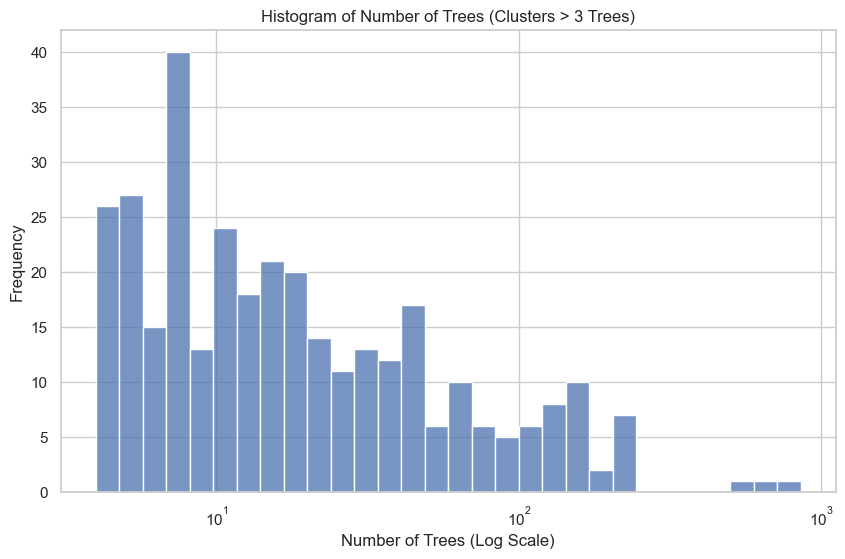

Number of clusters with >3 trees: 334


In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Filter clusters with more than 3 trees
larger_clusters = cluster_metrics_df[cluster_metrics_df['num_trees'] > 3]

# Set up plotting
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Histogram with log scale on x-axis
sns.histplot(larger_clusters['num_trees'], bins=30, log_scale=True)
plt.title('Histogram of Number of Trees (Clusters > 3 Trees)')
plt.xlabel('Number of Trees (Log Scale)')
plt.ylabel('Frequency')
plt.show()

print(f"Number of clusters with >3 trees: {len(larger_clusters)}")

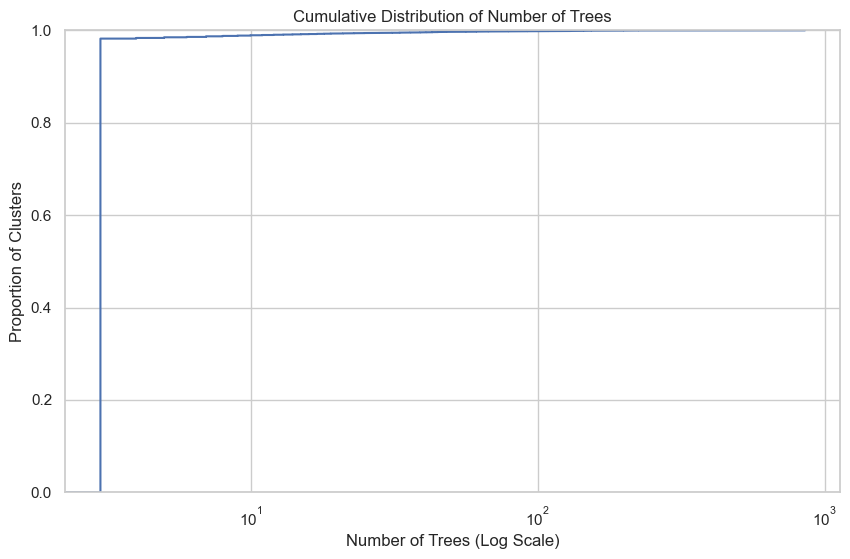

In [19]:
plt.figure(figsize=(10, 6))
sns.ecdfplot(data=cluster_metrics_df, x='num_trees')
plt.xscale('log')  # Optional: log scale for better tail visibility
plt.title('Cumulative Distribution of Number of Trees')
plt.xlabel('Number of Trees (Log Scale)')
plt.ylabel('Proportion of Clusters')
plt.grid(True)
plt.show()

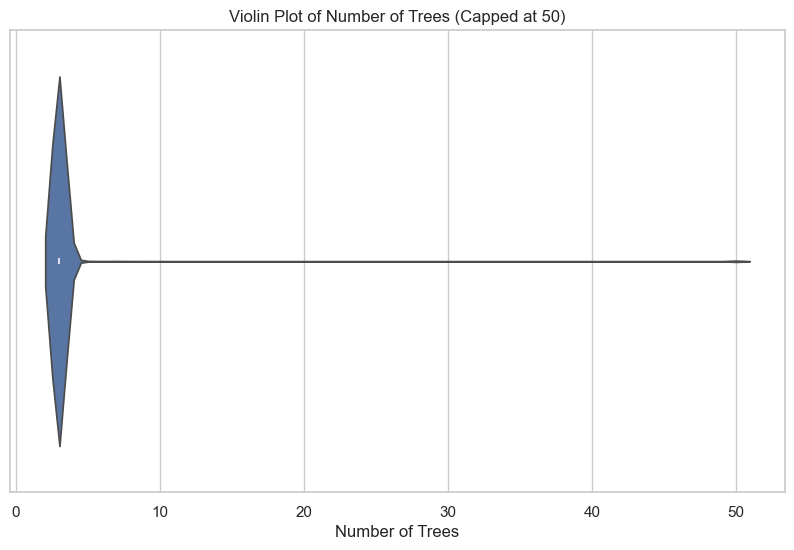

In [20]:
plt.figure(figsize=(10, 6))
sns.violinplot(x=cluster_metrics_df['num_trees'].clip(upper=50))  # Cap at 50 for visibility
plt.title('Violin Plot of Number of Trees (Capped at 50)')
plt.xlabel('Number of Trees')
plt.show()

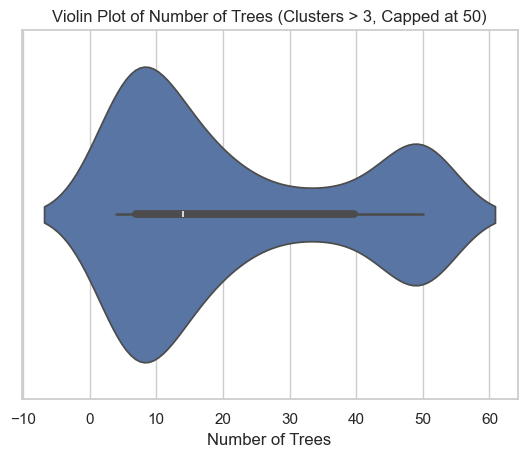

In [21]:
sns.violinplot(x=larger_clusters['num_trees'].clip(upper=50))
plt.title('Violin Plot of Number of Trees (Clusters > 3, Capped at 50)')
plt.xlabel('Number of Trees')
plt.show()

/var/folders/b1/qgbsvl0n4hlf_mxy5hyf7_740000gn/T/ipykernel_45958/3577408280.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  larger_clusters['num_trees_binned'] = pd.cut(larger_clusters['num_trees'], bins=bins, labels=labels, right=False)


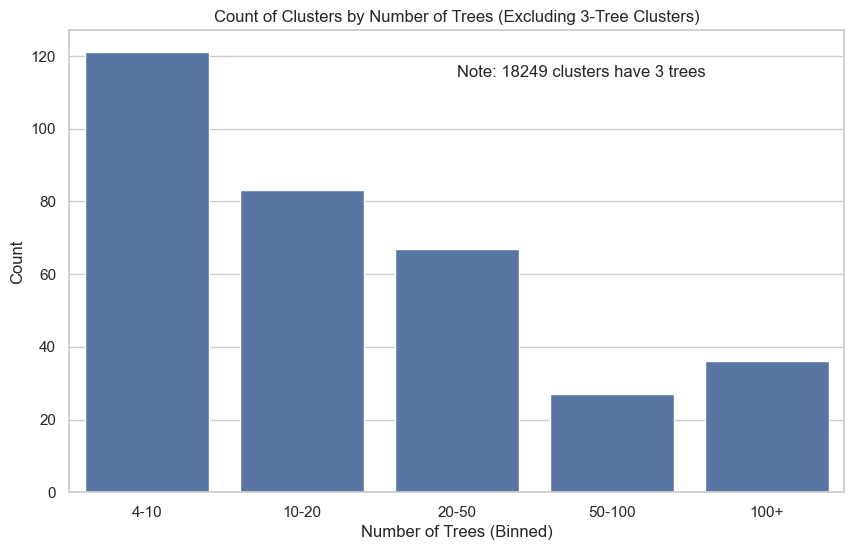

In [22]:
# Define bins excluding 3, then add a note for 3-tree clusters
bins = [4, 10, 20, 50, 100, float('inf')]
labels = ['4-10', '10-20', '20-50', '50-100', '100+']
larger_clusters['num_trees_binned'] = pd.cut(larger_clusters['num_trees'], bins=bins, labels=labels, right=False)

plt.figure(figsize=(10, 6))
sns.countplot(x='num_trees_binned', data=larger_clusters)
plt.title('Count of Clusters by Number of Trees (Excluding 3-Tree Clusters)')
plt.xlabel('Number of Trees (Binned)')
plt.ylabel('Count')
plt.text(0.5, 0.9, f'Note: {sum(cluster_metrics_df["num_trees"] == 3)} clusters have 3 trees', 
         transform=plt.gca().transAxes, fontsize=12)
plt.show()

Pearson Correlation Matrix:
                      area_m2  perimeter_m  compactness  circularity  \
area_m2              1.000000     0.670269     0.468116     0.468116   
perimeter_m          0.670269     1.000000    -0.197371    -0.197371   
compactness          0.468116    -0.197371     1.000000     1.000000   
circularity          0.468116    -0.197371     1.000000     1.000000   
convexity            0.004975     0.010008    -0.010276    -0.010276   
aspect_ratio_capped -0.407330     0.285069    -0.838297    -0.838297   
orientation_deg     -0.028656    -0.015364    -0.026552    -0.026552   
num_trees           -0.051630    -0.105378     0.084936     0.084936   

                     convexity  aspect_ratio_capped  orientation_deg  \
area_m2               0.004975            -0.407330        -0.028656   
perimeter_m           0.010008             0.285069        -0.015364   
compactness          -0.010276            -0.838297        -0.026552   
circularity          -0.010276     

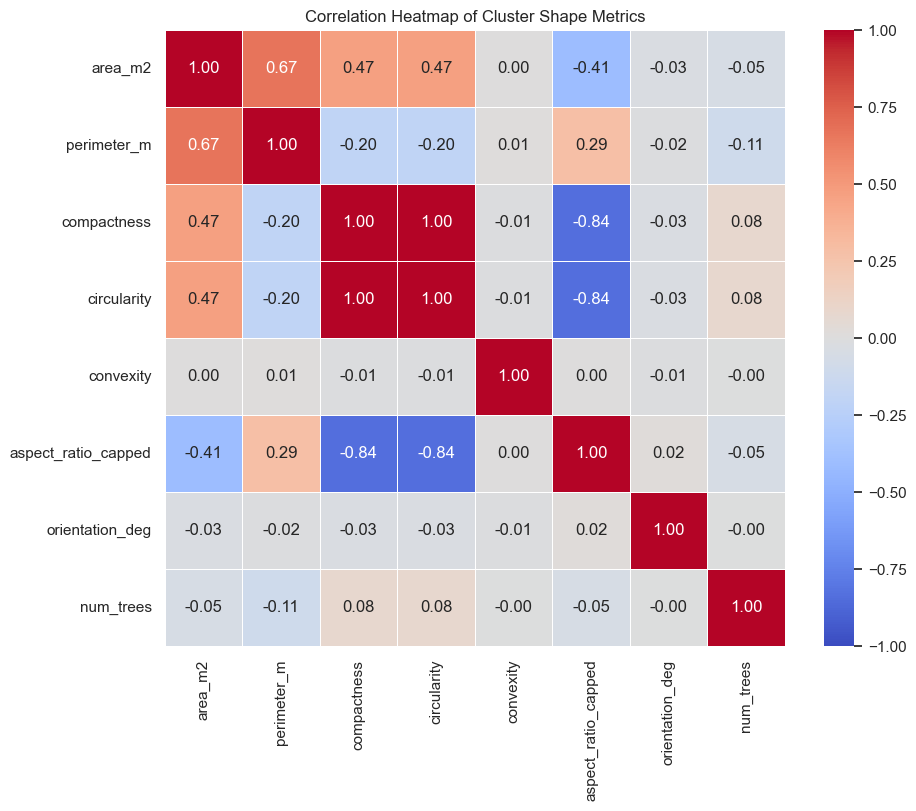


Spearman Correlation Matrix:
                      area_m2  perimeter_m  compactness  circularity  \
area_m2              1.000000     0.692546     0.473151     0.473151   
perimeter_m          0.692546     1.000000    -0.183581    -0.183581   
compactness          0.473151    -0.183581     1.000000     1.000000   
circularity          0.473151    -0.183581     1.000000     1.000000   
convexity            0.008177     0.011932    -0.011265    -0.011265   
aspect_ratio_capped -0.446304     0.224000    -0.989392    -0.989392   
orientation_deg     -0.028134    -0.017938    -0.027173    -0.027173   
num_trees           -0.190674    -0.228842     0.203418     0.203418   

                     convexity  aspect_ratio_capped  orientation_deg  \
area_m2               0.008177            -0.446304        -0.028134   
perimeter_m           0.011932             0.224000        -0.017938   
compactness          -0.011265            -0.989392        -0.027173   
circularity          -0.011265   

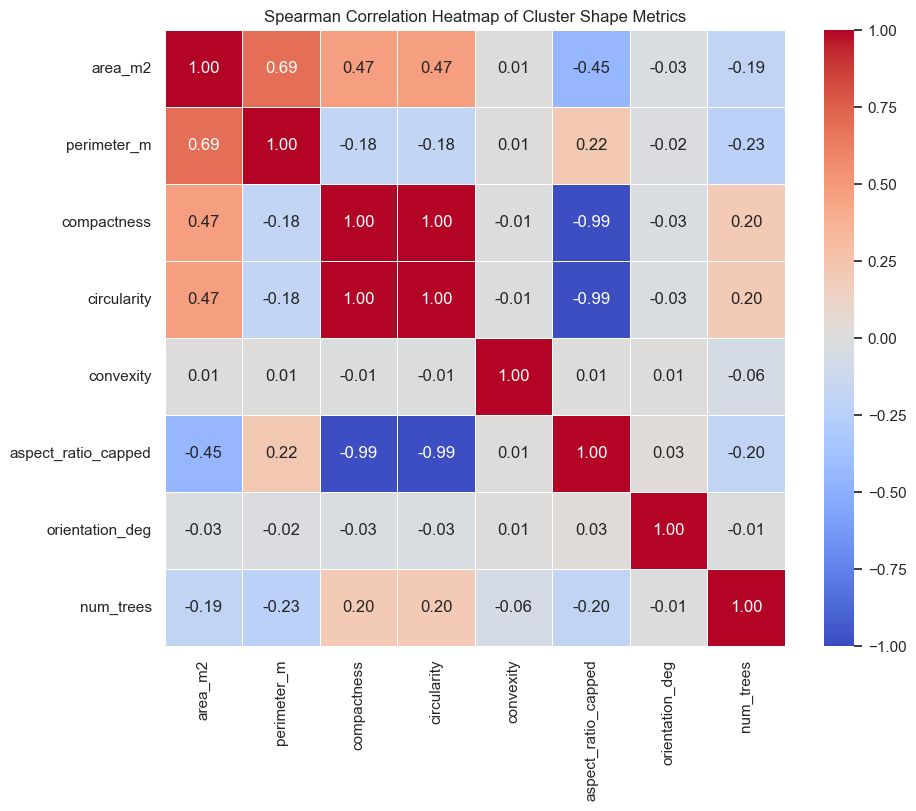

In [23]:
# Correlation and Relationship Analysis

# Import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'cluster_metrics_df' is your DataFrame with metrics
# Columns: 'cluster_id', 'area_m2', 'perimeter_m', 'compactness', 'circularity', 
# 'convexity', 'aspect_ratio', 'orientation_deg', 'num_trees'

# Select numeric columns for correlation (excluding 'cluster_id')
numeric_cols = ['area_m2', 'perimeter_m', 'compactness', 'circularity', 
                'convexity', 'aspect_ratio', 'orientation_deg', 'num_trees']

# Handle extreme aspect_ratio values (e.g., cap at 100 or use log transformation)
cluster_metrics_df['aspect_ratio_capped'] = cluster_metrics_df['aspect_ratio'].clip(upper=100)
numeric_cols_adjusted = ['area_m2', 'perimeter_m', 'compactness', 'circularity', 
                         'convexity', 'aspect_ratio_capped', 'orientation_deg', 'num_trees']

# 1. Compute Correlation Matrix (Pearson)
correlation_matrix = cluster_metrics_df[numeric_cols_adjusted].corr(method='pearson')

# 2. Display Correlation Matrix
print("Pearson Correlation Matrix:")
print(correlation_matrix)

# 3. Visualize with Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, 
            fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Cluster Shape Metrics')
plt.show()

# Optional: Spearman Correlation (for non-linear relationships)
spearman_corr = cluster_metrics_df[numeric_cols_adjusted].corr(method='spearman')
print("\nSpearman Correlation Matrix:")
print(spearman_corr)

# Visualize Spearman Correlation
plt.figure(figsize=(10, 8))
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, 
            fmt='.2f', linewidths=0.5)
plt.title('Spearman Correlation Heatmap of Cluster Shape Metrics')
plt.show()

In [24]:
# Define the key metrics
key_metrics = ['area_m2', 'perimeter_m', 'compactness', 'aspect_ratio_capped']

# Create a subset with only these metrics
df_key_metrics = cluster_metrics_df[key_metrics].copy()

In [25]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Standardize the data
df_scaled = pd.DataFrame(scaler.fit_transform(df_key_metrics), columns=key_metrics)

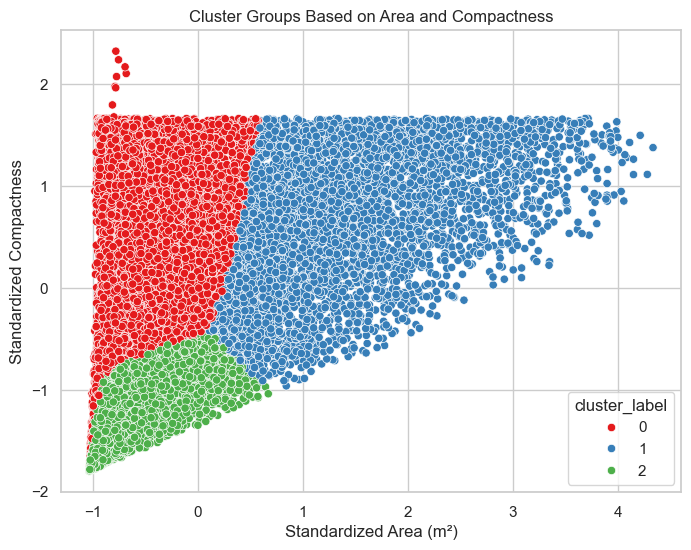

In [100]:
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

# Apply k-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df_scaled['cluster_label'] = kmeans.fit_predict(df_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x='area_m2', y='compactness', hue='cluster_label', data=df_scaled, palette='Set1')
plt.title('Cluster Groups Based on Area and Compactness')
plt.xlabel('Standardized Area (m²)')
plt.ylabel('Standardized Compactness')
plt.show()

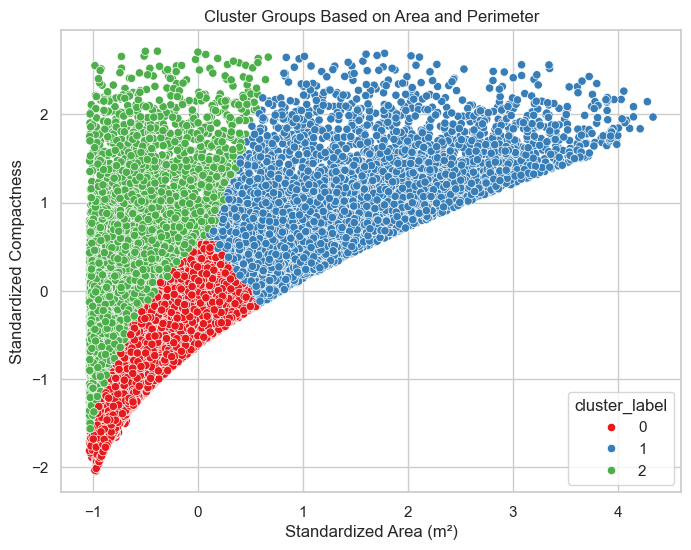

In [31]:
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

# Apply k-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df_scaled['cluster_label'] = kmeans.fit_predict(df_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x='area_m2', y='perimeter_m', hue='cluster_label', data=df_scaled, palette='Set1')
plt.title('Cluster Groups Based on Area and Perimeter')
plt.xlabel('Standardized Area (m²)')
plt.ylabel('Standardized Compactness')
plt.show()

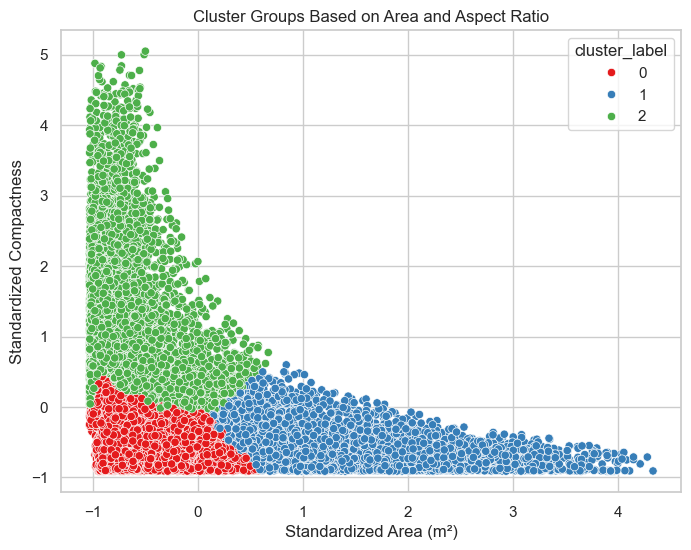

In [101]:
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

# Apply k-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df_scaled['cluster_label'] = kmeans.fit_predict(df_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x='area_m2', y='aspect_ratio_capped', hue='cluster_label', data=df_scaled, palette='Set1')
plt.title('Cluster Groups Based on Area and Aspect Ratio')
plt.xlabel('Standardized Area (m²)')
plt.ylabel('Standardized Compactness')
plt.show()

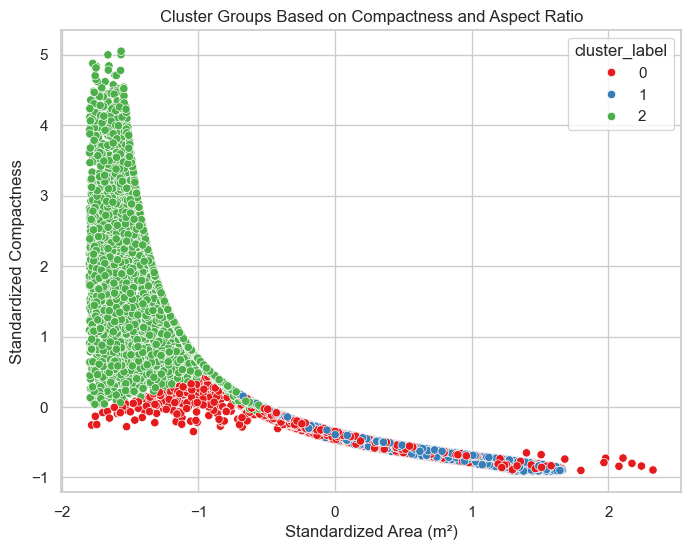

In [33]:
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

# Apply k-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
df_scaled['cluster_label'] = kmeans.fit_predict(df_scaled)

# Visualize the clusters (e.g., area vs. compactness)
plt.figure(figsize=(8, 6))
sns.scatterplot(x='compactness', y='aspect_ratio_capped', hue='cluster_label', data=df_scaled, palette='Set1')
plt.title('Cluster Groups Based on Compactness and Aspect Ratio')
plt.xlabel('Standardized Area (m²)')
plt.ylabel('Standardized Compactness')
plt.show()

In [27]:
# Add cluster labels to the original DataFrame
cluster_metrics_df['cluster_label'] = df_scaled['cluster_label']

# Compute mean values for each cluster
cluster_summary = cluster_metrics_df.groupby('cluster_label')[key_metrics].mean()
print(cluster_summary)

                 area_m2  perimeter_m  compactness  aspect_ratio_capped
cluster_label                                                          
0              21.671465    25.840001     0.388659             3.698057
1              88.539471    51.693599     0.419677             3.274178
2              15.714640    41.790131     0.103240            14.642148


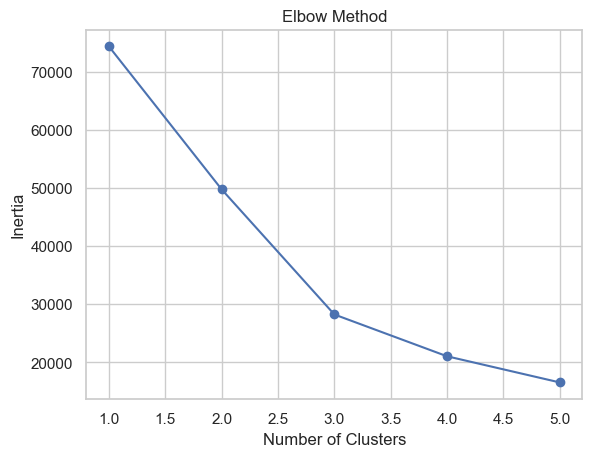

In [28]:
# Elbow method
inertia = []
for k in range(1, 6):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled[key_metrics])
    inertia.append(kmeans.inertia_)
plt.plot(range(1, 6), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

Spearman Correlation Matrix:
                      area_m2  perimeter_m  compactness  aspect_ratio_capped  \
area_m2              1.000000     0.692546     0.473151            -0.446304   
perimeter_m          0.692546     1.000000    -0.183581             0.224000   
compactness          0.473151    -0.183581     1.000000            -0.989392   
aspect_ratio_capped -0.446304     0.224000    -0.989392             1.000000   
num_trees           -0.190674    -0.228842     0.203418            -0.195216   

                     num_trees  
area_m2              -0.190674  
perimeter_m          -0.228842  
compactness           0.203418  
aspect_ratio_capped  -0.195216  
num_trees             1.000000  


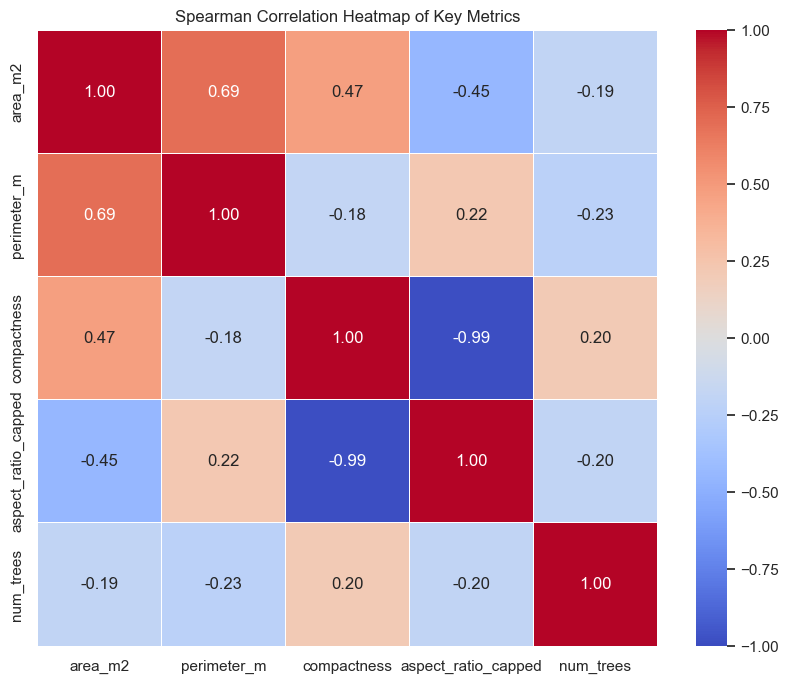

In [34]:
# Import required libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define the key metrics including num_trees
key_metrics = ['area_m2', 'perimeter_m', 'compactness', 'aspect_ratio_capped', 'num_trees']

# Create a subset with these metrics
df_key_metrics = cluster_metrics_df[key_metrics].copy()

# Compute Spearman correlation matrix
spearman_corr = df_key_metrics.corr(method='spearman')

# Display the Spearman correlation matrix
print("Spearman Correlation Matrix:")
print(spearman_corr)

# Visualize with a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, 
            fmt='.2f', linewidths=0.5)
plt.title('Spearman Correlation Heatmap of Key Metrics')
plt.show()

/Users/anisr/Documents/TreeClusters/venv/lib/python3.12/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


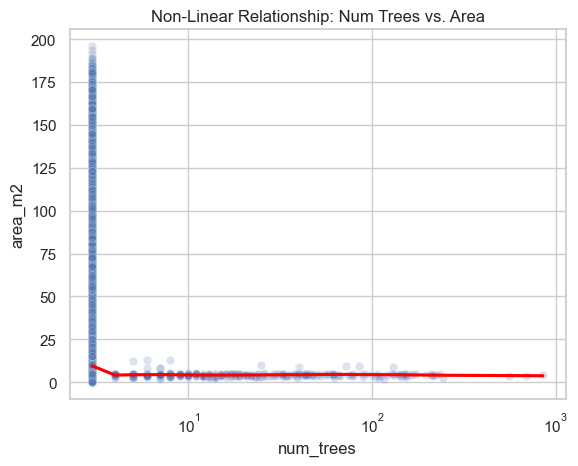

In [ ]:
sns.scatterplot(x='num_trees', y='area_m2', data=df_key_metrics, alpha=0.2)
sns.regplot(x='num_trees', y='area_m2', data=df_key_metrics, lowess=True, scatter=False, color='red')
plt.xscale('log')  # Optional for skewed data
plt.title('Non-Linear Relationship: Num Trees vs. Area')
plt.show()

/Users/anisr/Documents/TreeClusters/venv/lib/python3.12/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


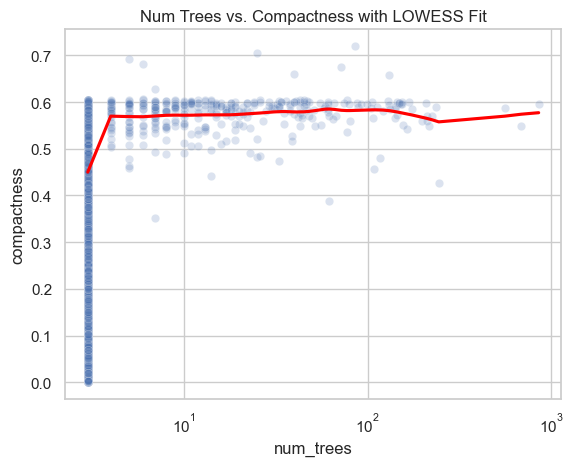

In [36]:
sns.scatterplot(x='num_trees', y='compactness', data=df_key_metrics, alpha=0.2)
sns.regplot(x='num_trees', y='compactness', data=df_key_metrics, lowess=True, scatter=False, color='red')
plt.xscale('log')
plt.title('Num Trees vs. Compactness with LOWESS Fit')
plt.show()

/Users/anisr/Documents/TreeClusters/venv/lib/python3.12/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


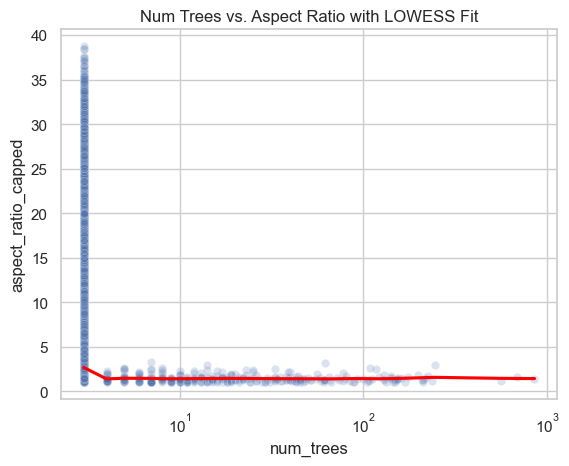

In [37]:
sns.scatterplot(x='num_trees', y='aspect_ratio_capped', data=df_key_metrics, alpha=0.2)
sns.regplot(x='num_trees', y='aspect_ratio_capped', data=df_key_metrics, lowess=True, scatter=False, color='red')
plt.xscale('log')
plt.title('Num Trees vs. Aspect Ratio with LOWESS Fit')
plt.show()

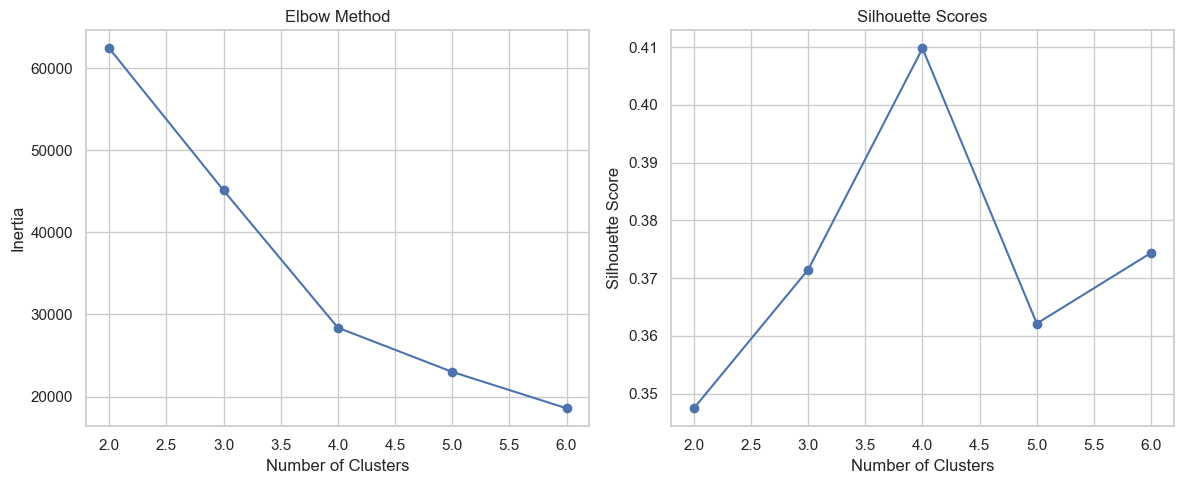

Cluster Characteristics (Mean Values):
                 area_m2  perimeter_m  compactness  aspect_ratio_capped  \
cluster_label                                                             
0              18.487930    38.514514     0.150920            11.616758   
1              54.857096    37.086331     0.445056             2.797090   
2               4.343075     9.653281     0.575245             1.409991   

               num_trees  
cluster_label             
0               3.000000  
1               3.008093  
2              46.231317  


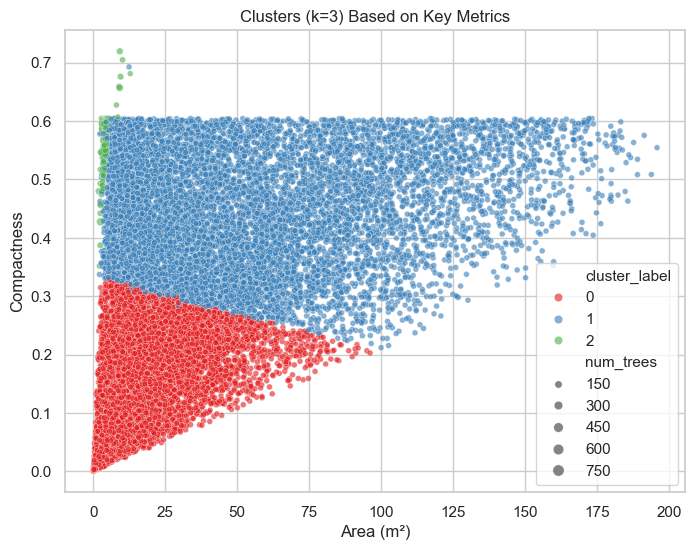

In [38]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns
import matplotlib.pyplot as plt

# Define key metrics
key_metrics = ['area_m2', 'perimeter_m', 'compactness', 'aspect_ratio_capped', 'num_trees']

# Create a subset with these metrics
df_key_metrics = cluster_metrics_df[key_metrics].copy()

# 1. Log-transform skewed metrics
df_key_metrics['log_aspect_ratio_capped'] = np.log1p(df_key_metrics['aspect_ratio_capped'])
df_key_metrics['log_num_trees'] = np.log1p(df_key_metrics['num_trees'] - 3)  # Shift to 0 base (3 -> 0)
transformed_metrics = ['area_m2', 'perimeter_m', 'compactness', 'log_aspect_ratio_capped', 'log_num_trees']

# 2. Standardize the transformed data
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_key_metrics[transformed_metrics]), 
                         columns=transformed_metrics)

# 3. Determine optimal number of clusters
# Elbow method
inertia = []
silhouette_scores = []
k_range = range(2, 7)  # Test 2 to 6 clusters
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(df_scaled, kmeans.labels_))

# Plot Elbow curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')

# Plot Silhouette scores
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, marker='o')
plt.title('Silhouette Scores')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.tight_layout()
plt.show()

# 4. Run k-means with optimal k (e.g., choose from elbow/silhouette)
optimal_k = 3  # Adjust based on elbow/silhouette results
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df_scaled['cluster_label'] = kmeans.fit_predict(df_scaled)

# Add cluster labels back to original DataFrame
df_key_metrics['cluster_label'] = df_scaled['cluster_label']

# 5. Summarize cluster characteristics (original units)
cluster_summary = df_key_metrics.groupby('cluster_label')[key_metrics].mean()
print("Cluster Characteristics (Mean Values):")
print(cluster_summary)

# Visualize clusters (e.g., area vs. compactness)
plt.figure(figsize=(8, 6))
sns.scatterplot(x='area_m2', y='compactness', hue='cluster_label', size='num_trees', 
                data=df_key_metrics, palette='Set1', alpha=0.6)
plt.title(f'Clusters (k={optimal_k}) Based on Key Metrics')
plt.xlabel('Area (m²)')
plt.ylabel('Compactness')
plt.show()

/var/folders/b1/qgbsvl0n4hlf_mxy5hyf7_740000gn/T/ipykernel_45958/4196922614.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_summary = df_key_metrics.groupby('num_trees_bin')[['area_m2', 'compactness', 'aspect_ratio_capped']].mean()


Mean Values by Num_trees Bins:
                 area_m2  compactness  aspect_ratio_capped
num_trees_bin                                             
3-10           38.006841     0.310757             6.833080
10-20           4.119870     0.572314             1.405440
20-50           4.377294     0.579689             1.398435
50-100          4.576646     0.583385             1.386452
100+            4.201119     0.573150             1.450832


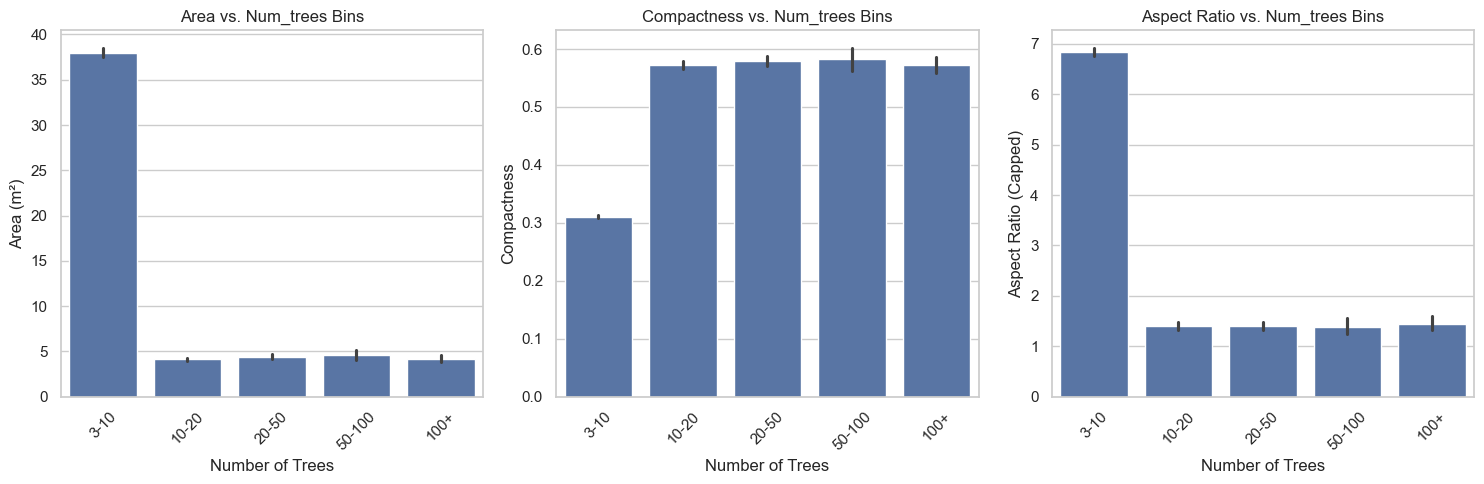


Threshold: 10 trees
Below 10 - Mean Area: 38.01, Compactness: 0.31, Aspect Ratio: 6.83
Above 10 - Mean Area: 4.27, Compactness: 0.58, Aspect Ratio: 1.41

Threshold: 20 trees
Below 20 - Mean Area: 37.85, Compactness: 0.31, Aspect Ratio: 6.81
Above 20 - Mean Area: 4.37, Compactness: 0.58, Aspect Ratio: 1.41

Threshold: 50 trees
Below 50 - Mean Area: 37.73, Compactness: 0.31, Aspect Ratio: 6.79
Above 50 - Mean Area: 4.36, Compactness: 0.58, Aspect Ratio: 1.42


In [39]:
# Import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Use the subset with key metrics from your clustering
key_metrics = ['area_m2', 'compactness', 'aspect_ratio_capped', 'num_trees']
df_key_metrics = cluster_metrics_df[key_metrics].copy()

# 1. Define bins for num_trees
bins = [3, 10, 20, 50, 100, float('inf')]  # Adjust based on your data
labels = ['3-10', '10-20', '20-50', '50-100', '100+']
df_key_metrics['num_trees_bin'] = pd.cut(df_key_metrics['num_trees'], bins=bins, labels=labels, right=False)

# 2. Calculate mean values for each bin
bin_summary = df_key_metrics.groupby('num_trees_bin')[['area_m2', 'compactness', 'aspect_ratio_capped']].mean()
print("Mean Values by Num_trees Bins:")
print(bin_summary)

# 3. Visualize trends
plt.figure(figsize=(15, 5))

# Area vs. Num_trees
plt.subplot(1, 3, 1)
sns.barplot(x='num_trees_bin', y='area_m2', data=df_key_metrics)
plt.title('Area vs. Num_trees Bins')
plt.xlabel('Number of Trees')
plt.ylabel('Area (m²)')
plt.xticks(rotation=45)

# Compactness vs. Num_trees
plt.subplot(1, 3, 2)
sns.barplot(x='num_trees_bin', y='compactness', data=df_key_metrics)
plt.title('Compactness vs. Num_trees Bins')
plt.xlabel('Number of Trees')
plt.ylabel('Compactness')
plt.xticks(rotation=45)

# Aspect Ratio vs. Num_trees
plt.subplot(1, 3, 3)
sns.barplot(x='num_trees_bin', y='aspect_ratio_capped', data=df_key_metrics)
plt.title('Aspect Ratio vs. Num_trees Bins')
plt.xlabel('Number of Trees')
plt.ylabel('Aspect Ratio (Capped)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# 4. Test specific thresholds with statistical comparison (e.g., t-test or median split)
thresholds = [10, 20, 50]
for thresh in thresholds:
    below = df_key_metrics[df_key_metrics['num_trees'] < thresh]
    above = df_key_metrics[df_key_metrics['num_trees'] >= thresh]
    print(f"\nThreshold: {thresh} trees")
    print(f"Below {thresh} - Mean Area: {below['area_m2'].mean():.2f}, Compactness: {below['compactness'].mean():.2f}, Aspect Ratio: {below['aspect_ratio_capped'].mean():.2f}")
    print(f"Above {thresh} - Mean Area: {above['area_m2'].mean():.2f}, Compactness: {above['compactness'].mean():.2f}, Aspect Ratio: {above['aspect_ratio_capped'].mean():.2f}")

In [40]:
from scipy.stats import mannwhitneyu
below_10 = df_key_metrics[df_key_metrics['num_trees'] < 10]['area_m2']
above_10 = df_key_metrics[df_key_metrics['num_trees'] >= 10]['area_m2']
stat, p = mannwhitneyu(below_10, above_10)
print(f"Mann-Whitney U test for Area at 10 trees: p-value = {p:.4f}")

Mann-Whitney U test for Area at 10 trees: p-value = 0.0000


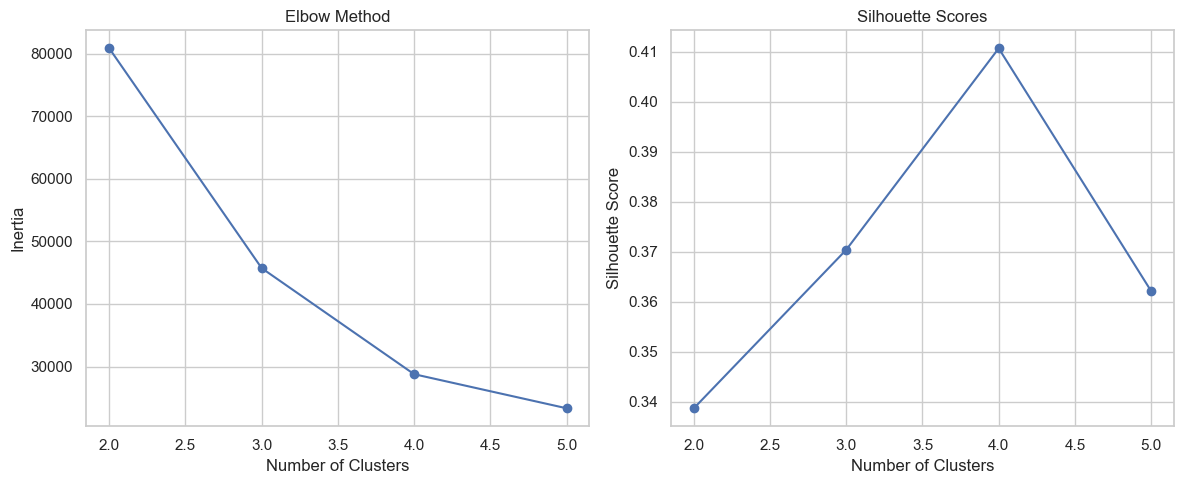

Refined Cluster Characteristics (Mean Values):
                 area_m2  perimeter_m  compactness  aspect_ratio_capped  \
cluster_label                                                             
0              19.073878    38.711807     0.152780            11.518493   
1              53.435376    36.130164     0.451106             2.722436   

               num_trees  is_dense  
cluster_label                       
0               3.000000  0.000000  
1               4.219143  0.021236  


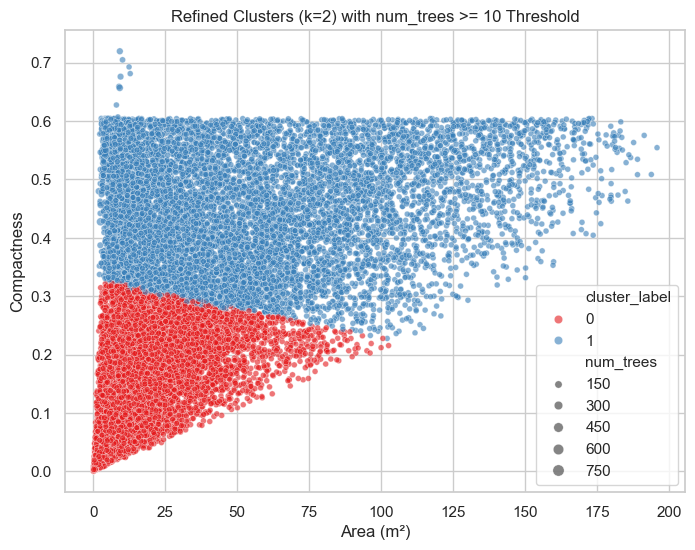

In [53]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns
import matplotlib.pyplot as plt

# Define key metrics
key_metrics = ['area_m2', 'perimeter_m', 'compactness', 'aspect_ratio_capped', 'num_trees']

# Create a subset with these metrics
df_key_metrics = cluster_metrics_df[key_metrics].copy()

# 1. Add binary feature for num_trees >= 10
df_key_metrics['is_dense'] = (df_key_metrics['num_trees'] >= 10).astype(int)

# 2. Log-transform skewed metrics
df_key_metrics['log_aspect_ratio_capped'] = np.log1p(df_key_metrics['aspect_ratio_capped'])
df_key_metrics['log_num_trees'] = np.log1p(df_key_metrics['num_trees'] - 3)  # Shift to 0 base (3 -> 0)

# Define features for clustering (original + transformed + binary)
features = ['area_m2', 'perimeter_m', 'compactness', 'log_aspect_ratio_capped', 'log_num_trees', 'is_dense']

# 3. Standardize the data
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_key_metrics[features]), columns=features)

# 4. Determine optimal number of clusters
inertia = []
silhouette_scores = []
k_range = range(2, 6)  # Test 2 to 5 clusters
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(df_scaled, kmeans.labels_))

# Plot Elbow curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')

# Plot Silhouette scores
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, marker='o')
plt.title('Silhouette Scores')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.tight_layout()
plt.show()

# 5. Run k-means with optimal k (e.g., choose based on elbow/silhouette)
optimal_k = 2  # Adjust after reviewing plots (2 may split sparse vs. dense)
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df_scaled['cluster_label'] = kmeans.fit_predict(df_scaled)

# Add cluster labels back to original DataFrame
df_key_metrics['cluster_label'] = df_scaled['cluster_label']

# Summarize cluster characteristics in original units
cluster_summary = df_key_metrics.groupby('cluster_label')[key_metrics + ['is_dense']].mean()
print("Refined Cluster Characteristics (Mean Values):")
print(cluster_summary)

# Visualize clusters (e.g., area vs. compactness with num_trees as size)
plt.figure(figsize=(8, 6))
sns.scatterplot(x='area_m2', y='compactness', hue='cluster_label', size='num_trees', 
                data=df_key_metrics, palette='Set1', alpha=0.6)
plt.title(f'Refined Clusters (k={optimal_k}) with num_trees >= 10 Threshold')
plt.xlabel('Area (m²)')
plt.ylabel('Compactness')
plt.show()

Refined Cluster Characteristics (Mean Values, k=3):
                 area_m2  perimeter_m  compactness  aspect_ratio_capped  \
cluster_label                                                             
0              19.073878    38.711807     0.152780            11.518493   
1               4.272477     9.585646     0.576178             1.408501   
2              54.502067    36.706102     0.448392             2.750944   

               num_trees  is_dense  
cluster_label                       
0               3.000000       0.0  
1              58.629108       1.0  
2               3.038606       0.0  


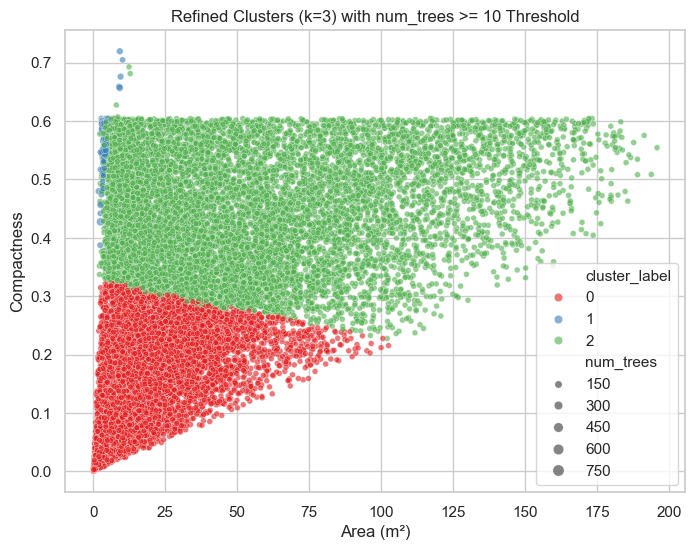

In [54]:
# Adjust optimal_k
optimal_k = 3  # Based on elbow and ecological insight
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df_scaled['cluster_label'] = kmeans.fit_predict(df_scaled)

# Update summary and visualization
df_key_metrics['cluster_label'] = df_scaled['cluster_label']
cluster_summary = df_key_metrics.groupby('cluster_label')[key_metrics + ['is_dense']].mean()
print("Refined Cluster Characteristics (Mean Values, k=3):")
print(cluster_summary)

plt.figure(figsize=(8, 6))
sns.scatterplot(x='area_m2', y='compactness', hue='cluster_label', size='num_trees', 
                data=df_key_metrics, palette='Set1', alpha=0.6)
plt.title(f'Refined Clusters (k={optimal_k}) with num_trees >= 10 Threshold')
plt.xlabel('Area (m²)')
plt.ylabel('Compactness')
plt.show()

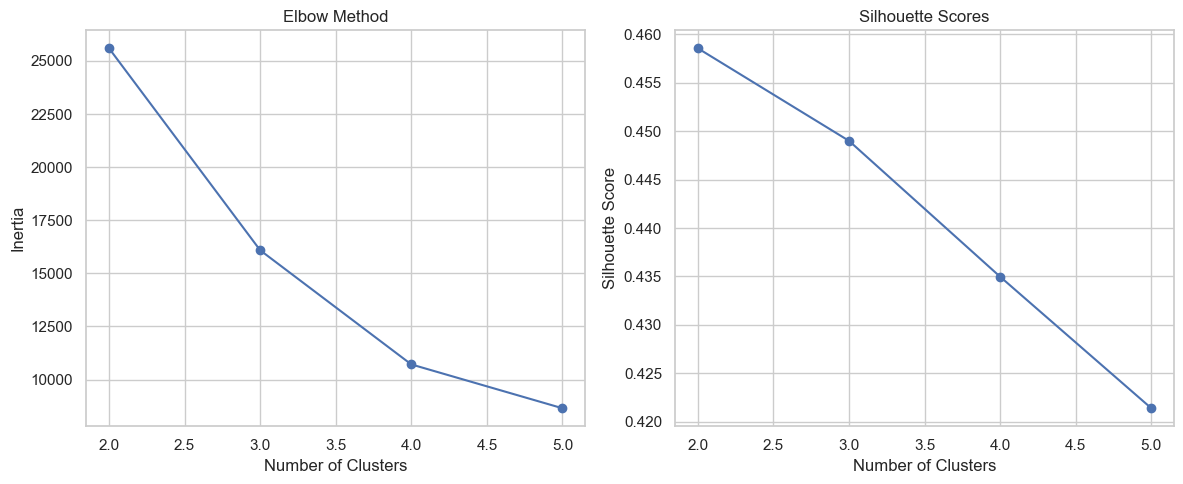

Cluster Characteristics (Mean Values, k=3):
                  area_m2  compactness  aspect_ratio_capped
cluster_label                                              
0               17.742274     0.133875            12.471586
1              103.705383     0.466513             2.605150
2               29.031759     0.420658             3.106383


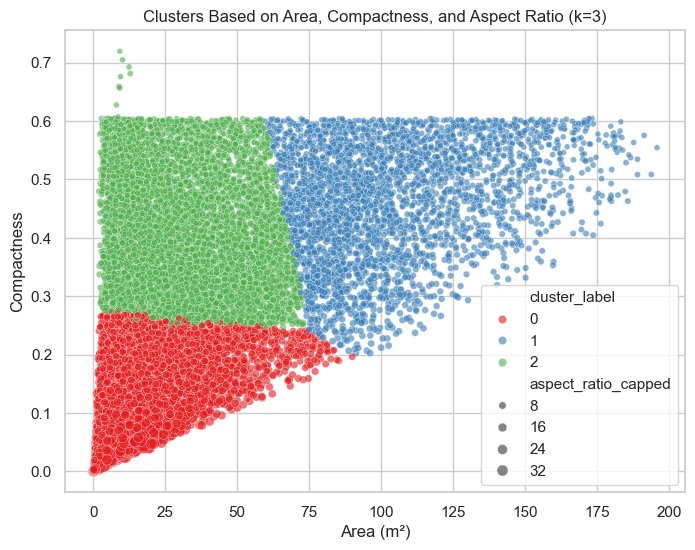

In [55]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns
import matplotlib.pyplot as plt

# Define the subset with selected metrics
selected_metrics = ['area_m2', 'compactness', 'aspect_ratio_capped']
df_selected_metrics = cluster_metrics_df[selected_metrics].copy()

# 1. Log-transform aspect_ratio_capped for skewness
df_selected_metrics['log_aspect_ratio_capped'] = np.log1p(df_selected_metrics['aspect_ratio_capped'])

# Update features for clustering
features = ['area_m2', 'compactness', 'log_aspect_ratio_capped']

# 2. Standardize the data
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_selected_metrics[features]), columns=features)

# 3. Determine optimal number of clusters
inertia = []
silhouette_scores = []
k_range = range(2, 6)  # Test 2 to 5 clusters
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(df_scaled, kmeans.labels_))

# Plot Elbow curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')

# Plot Silhouette scores
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, marker='o')
plt.title('Silhouette Scores')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.tight_layout()
plt.show()

# 4. Run k-means with optimal k (choose based on plots)
optimal_k = 3  # Adjust after reviewing plots (e.g., 2 or 3 based on previous results)
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df_scaled['cluster_label'] = kmeans.fit_predict(df_scaled)

# Add cluster labels back to original DataFrame
df_selected_metrics['cluster_label'] = df_scaled['cluster_label']

# 5. Summarize cluster characteristics in original units
cluster_summary = df_selected_metrics.groupby('cluster_label')[selected_metrics].mean()
print("Cluster Characteristics (Mean Values, k={}):".format(optimal_k))
print(cluster_summary)

# Visualize clusters (area vs. compactness with aspect ratio as color intensity)
plt.figure(figsize=(8, 6))
sns.scatterplot(x='area_m2', y='compactness', hue='cluster_label', size='aspect_ratio_capped', 
                data=df_selected_metrics, palette='Set1', alpha=0.6)
plt.title('Clusters Based on Area, Compactness, and Aspect Ratio (k={})'.format(optimal_k))
plt.xlabel('Area (m²)')
plt.ylabel('Compactness')
plt.show()

In [56]:
# optimal_k = 2
# kmeans = KMeans(n_clusters=optimal_k, random_state=42)
# df_scaled['cluster_label'] = kmeans.fit_predict(df_scaled)
# df_selected_metrics['cluster_label'] = df_scaled['cluster_label']
# cluster_summary = df_selected_metrics.groupby('cluster_label')[selected_metrics].mean()
# print("Cluster Characteristics (Mean Values, k=2):")
# print(cluster_summary)

In [50]:
# Unsupervised Cluster Categorization

# Add num_trees to the previous code
selected_metrics = ['area_m2', 'compactness', 'aspect_ratio_capped', 'num_trees']
df_selected_metrics = cluster_metrics_df[selected_metrics].copy()
df_selected_metrics['log_aspect_ratio_capped'] = np.log1p(df_selected_metrics['aspect_ratio_capped'])
df_selected_metrics['log_num_trees'] = np.log1p(df_selected_metrics['num_trees'] - 3)
features = ['area_m2', 'compactness', 'log_aspect_ratio_capped', 'log_num_trees']

# Re-standardize and cluster (k=3 as before)
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_selected_metrics[features]), columns=features)
kmeans = KMeans(n_clusters=3, random_state=42)
df_scaled['cluster_label'] = kmeans.fit_predict(df_scaled)
df_selected_metrics['cluster_label'] = df_scaled['cluster_label']
cluster_summary = df_selected_metrics.groupby('cluster_label')[selected_metrics].mean()
print("Cluster Characteristics with Num Trees (k=3):")
print(cluster_summary)

Cluster Characteristics with Num Trees (k=3):
                 area_m2  compactness  aspect_ratio_capped  num_trees
cluster_label                                                        
0              18.220070     0.152171            11.569495   3.000000
1               4.309042     0.575021             1.408105  48.500000
2              55.180946     0.445560             2.794449   3.012685



Merged DataFrame Shape: (18583, 11)
Columns in df_analysis: ['cluster_id', 'area_m2', 'perimeter_m', 'compactness', 'circularity', 'convexity', 'aspect_ratio', 'orientation_deg', 'num_trees', 'x', 'y']
Computing 'density' as num_trees / area_m2
('WARNING: ', 408, ' is an island (no neighbors)')
('WARNING: ', 409, ' is an island (no neighbors)')
('WARNING: ', 412, ' is an island (no neighbors)')
('WARNING: ', 417, ' is an island (no neighbors)')
('WARNING: ', 418, ' is an island (no neighbors)')
('WARNING: ', 419, ' is an island (no neighbors)')
('WARNING: ', 551, ' is an island (no neighbors)')
('WARNING: ', 554, ' is an island (no neighbors)')
('WARNING: ', 555, ' is an island (no neighbors)')
('WARNING: ', 558, ' is an island (no neighbors)')
('WARNING: ', 565, ' is an island (no neighbors)')
('WARNING: ', 590, ' is an island (no neighbors)')
('WARNING: ', 673, ' is an island (no neighbors)')
('WARNING: ', 800, ' is an island (no neighbors)')
('WARNING: ', 977, ' is an island (no ne

/Users/anisr/Documents/TreeClusters/venv/lib/python3.12/site-packages/esda/getisord.py:527: RuntimeWarning: invalid value encountered in divide
  z_scores = (statistic - expected_value) / np.sqrt(expected_variance)
/Users/anisr/Documents/TreeClusters/venv/lib/python3.12/site-packages/esda/getisord.py:450: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Gs - self.EG_sim) / self.seG_sim


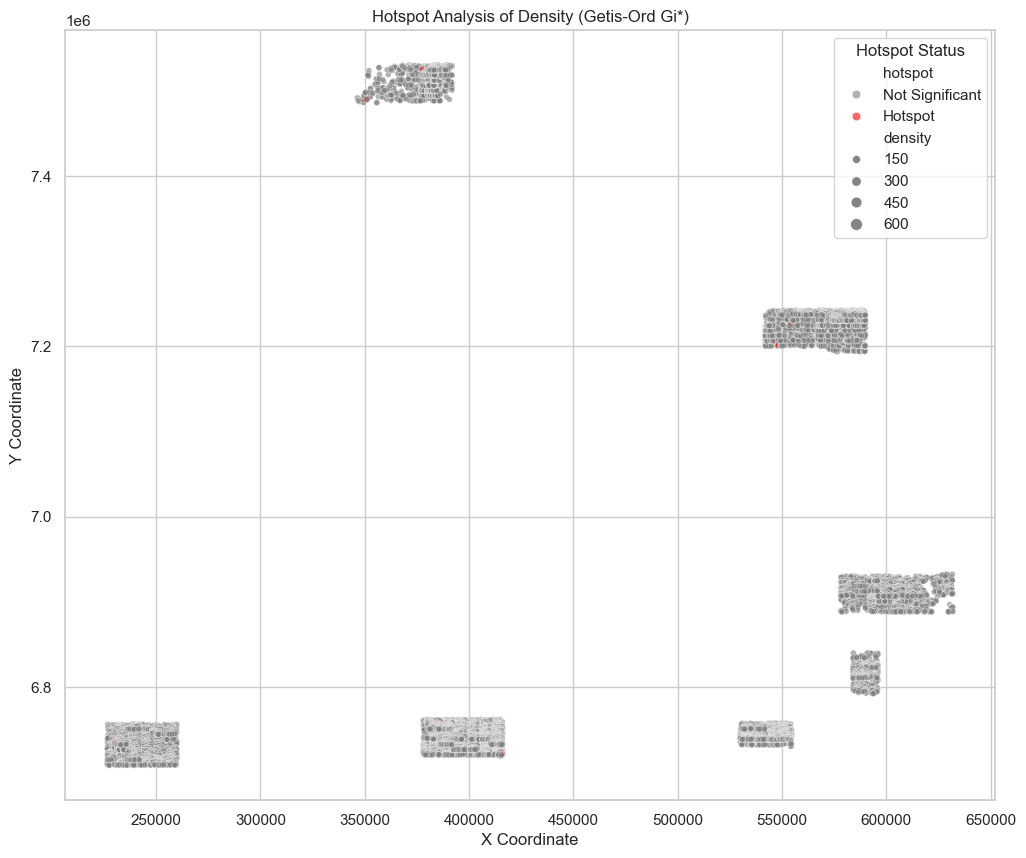


Hotspot Summary by Cluster:
hotspot     Hotspot  Not Significant
cluster_id                          
2                 0                1
4                 0                1
5                 0                1
7                 0                1
8                 0                1
...             ...              ...
43522             0                1
43523             0                1
43530             0                1
43533             0                1
43536             0                1

[18583 rows x 2 columns]

Mean Aspect Ratio and Compactness by Cluster and Hotspot Status:
           aspect_ratio                 compactness                
hotspot         Hotspot Not Significant     Hotspot Not Significant
cluster_id                                                         
2                   0.0        2.663964         0.0        0.450050
4                   0.0       28.209935         0.0        0.055542
5                   0.0        3.880407         0.0       

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from libpysal.weights import DistanceBand
from esda.moran import Moran
from esda.getisord import G_Local

# Step 1: Create DataFrame from gdf with spatial coordinates
df_analysis = cluster_metrics_df.copy()

# Verify the merge
print("\nMerged DataFrame Shape:", df_analysis.shape)
print("Columns in df_analysis:", df_analysis.columns.tolist())

# Check if 'density' is now present
if 'density' not in df_analysis.columns:
    # If 'density' is missing, compute it if num_trees and area_m2 are available
    if 'num_trees' in df_analysis.columns and 'area_m2' in df_analysis.columns:
        print("Computing 'density' as num_trees / area_m2")
        df_analysis['density'] = df_analysis['num_trees'] / df_analysis['area_m2']
    else:
        raise ValueError("Cannot compute 'density': 'num_trees' or 'area_m2' missing in df_analysis")

# # Step 3: Visualize spatial distribution
# plt.figure(figsize=(12, 10))
# sns.scatterplot(x='x', y='y', hue='cluster_id', size='num_trees', 
#                 data=df_analysis, palette='Set1', alpha=0.6)
# plt.title('Spatial Distribution of Clusters by Label and Tree Count')
# plt.xlabel('X Coordinate')
# plt.ylabel('Y Coordinate')
# plt.legend(title='Cluster Label')
# plt.show()

# Step 4: Spatial autocorrelation (Moran's I for density)
# Create spatial weights matrix (distance-based)
coords = df_analysis[['x', 'y']].values
w = DistanceBand.from_array(coords, threshold=1000)  # Adjust threshold (e.g., 1000 meters) based on your data's scale
w.transform = 'r'  # Row-standardize weights

# Compute Moran's I for density
moran = Moran(df_analysis['density'], w)
print("\nMoran's I for Density:")
print(f"Moran's I: {moran.I:.3f}")
print(f"p-value: {moran.p_sim:.3f}")
print(f"Interpretation: {'Significant spatial autocorrelation' if moran.p_sim < 0.05 else 'No significant spatial autocorrelation'}")

# Step 5: Hotspot analysis (Getis-Ord Gi* for density)
gi = G_Local(df_analysis['density'], w)
df_analysis['gi_z'] = gi.Zs  # Z-scores for hotspot detection
df_analysis['gi_p'] = gi.p_sim  # p-values for significance

# Identify hotspots and coldspots
df_analysis['hotspot'] = 'Not Significant'
df_analysis.loc[(df_analysis['gi_z'] > 1.96) & (df_analysis['gi_p'] < 0.05), 'hotspot'] = 'Hotspot'
df_analysis.loc[(df_analysis['gi_z'] < -1.96) & (df_analysis['gi_p'] < 0.05), 'hotspot'] = 'Coldspot'

# Visualize hotspots
plt.figure(figsize=(12, 10))
sns.scatterplot(x='x', y='y', hue='hotspot', size='density', 
                data=df_analysis, palette={'Hotspot': 'red', 'Coldspot': 'blue', 'Not Significant': 'grey'}, 
                alpha=0.6)
plt.title('Hotspot Analysis of Density (Getis-Ord Gi*)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend(title='Hotspot Status')
plt.show()

# Step 6: Summarize hotspots by cluster
print("\nHotspot Summary by Cluster:")
print(df_analysis.groupby(['cluster_id', 'hotspot']).size().unstack(fill_value=0))

# Step 7: Analyze aspect ratio and compactness by spatial pattern
print("\nMean Aspect Ratio and Compactness by Cluster and Hotspot Status:")
print(df_analysis.groupby(['cluster_id', 'hotspot'])[['aspect_ratio', 'compactness']].mean().unstack(fill_value=0))

Refined Cluster Characteristics (Mean Values, k=3 with Forced Separation):
                 area_m2  perimeter_m  compactness  aspect_ratio_capped  \
cluster_label                                                             
0.0            38.333698    37.637786     0.311451             6.796079   
1.0            37.470310    37.548940     0.310115             6.865422   
2.0             4.272477     9.585646     0.576178             1.408501   

               num_trees  
cluster_label             
0.0             3.023298  
1.0             3.018012  
2.0            58.629108  

Cluster Sizes:
cluster_label
0.0    9829
1.0    8328
2.0     213
Name: count, dtype: int64

Cluster Density Summary:
               density_mean  density_median  density_std  density_min  \
cluster_label                                                           
0.0                0.558218        0.118003     7.338502     0.015475   
1.0                0.605915        0.119938     8.738544     0.015318   
2.0 

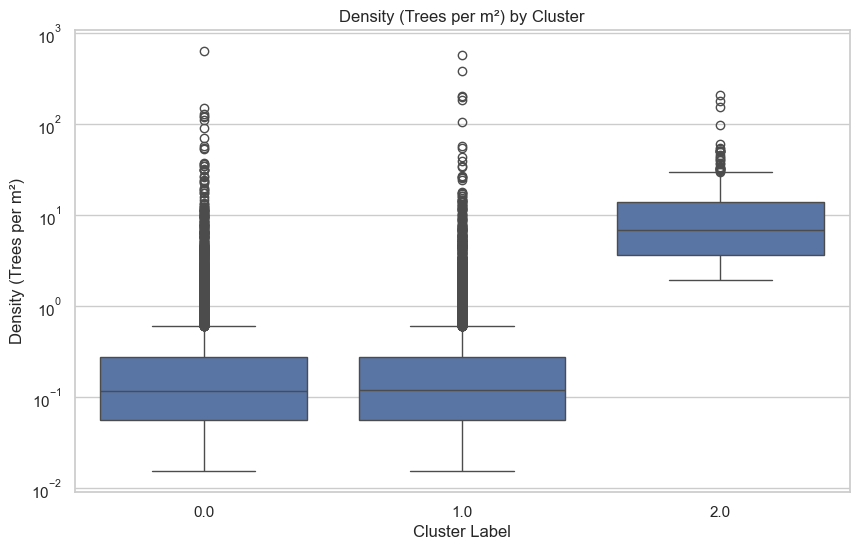


Spearman Correlation of Density with Spatial Metrics:
                      density   area_m2  compactness  aspect_ratio_capped
density              1.000000 -0.999388    -0.462640             0.436906
area_m2             -0.999388  1.000000     0.473151            -0.446304
compactness         -0.462640  0.473151     1.000000            -0.989392
aspect_ratio_capped  0.436906 -0.446304    -0.989392             1.000000


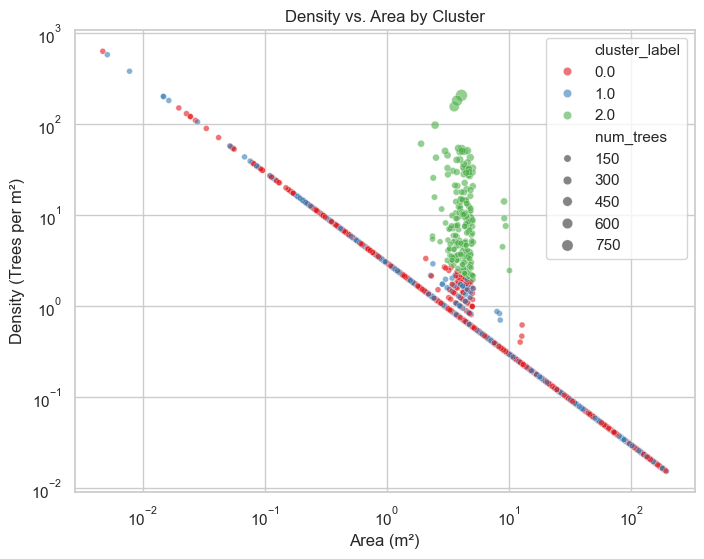

In [61]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

# Define key metrics
key_metrics = ['area_m2', 'perimeter_m', 'compactness', 'aspect_ratio_capped', 'num_trees']

# Create a subset with these metrics
df_clustered = cluster_metrics_df[key_metrics].copy()

# 1. Split data based on num_trees >= 10 (from threshold analysis)
sparse_df = df_clustered[df_clustered['num_trees'] < 10].copy()
dense_df = df_clustered[df_clustered['num_trees'] >= 10].copy()

# 2. Log-transform skewed metrics for both subsets
for df in [sparse_df, dense_df]:
    df['log_aspect_ratio_capped'] = np.log1p(df['aspect_ratio_capped'])
    df['log_num_trees'] = np.log1p(df['num_trees'] - 3)  # Shift to 0 base (3 -> 0)

# Features for clustering (excluding num_trees since we're using it for separation)
features = ['area_m2', 'perimeter_m', 'compactness', 'log_aspect_ratio_capped', 'log_num_trees']

# 3. Standardize both subsets
scaler = StandardScaler()
sparse_scaled = pd.DataFrame(scaler.fit_transform(sparse_df[features]), columns=features)
dense_scaled = pd.DataFrame(scaler.fit_transform(dense_df[features]), columns=features)

# 4. Cluster sparse data (k=2 to split sparse clusters)
kmeans_sparse = KMeans(n_clusters=2, random_state=42)
sparse_scaled['cluster_label'] = kmeans_sparse.fit_predict(sparse_scaled)
sparse_df['cluster_label'] = sparse_scaled['cluster_label']

# 5. Cluster dense data (k=1, as a single dense cluster)
dense_scaled['cluster_label'] = 2  # Assign label 2 for dense clusters
dense_df['cluster_label'] = 2

# 6. Combine the results
df_combined = pd.concat([sparse_df, dense_df], ignore_index=True)

# 7. Summarize cluster characteristics
cluster_summary = df_combined.groupby('cluster_label')[key_metrics].mean()
print("Refined Cluster Characteristics (Mean Values, k=3 with Forced Separation):")
print(cluster_summary)

# Cluster sizes
print("\nCluster Sizes:")
print(df_combined['cluster_label'].value_counts())

# 8. Compute density (trees per m²)
df_combined['density'] = df_combined['num_trees'] / df_combined['area_m2']

# 9. Summarize density within each cluster
density_summary = df_combined.groupby('cluster_label').agg({
    'density': ['mean', 'median', 'std', 'min', 'max'],
    'num_trees': ['mean'],
    'area_m2': ['mean']
})
density_summary.columns = ['density_mean', 'density_median', 'density_std', 'density_min', 'density_max', 
                           'num_trees_mean', 'area_m2_mean']
print("\nCluster Density Summary:")
print(density_summary)

# 10. Visualize density across clusters
plt.figure(figsize=(10, 6))
sns.boxplot(x='cluster_label', y='density', data=df_combined)
plt.title('Density (Trees per m²) by Cluster')
plt.xlabel('Cluster Label')
plt.ylabel('Density (Trees per m²)')
plt.yscale('log')  # Log scale due to skewness in density
plt.show()

# 11. Correlate density with spatial metrics
corr_metrics = ['density', 'area_m2', 'compactness', 'aspect_ratio_capped']
spearman_corr = df_combined[corr_metrics].corr(method='spearman')
print("\nSpearman Correlation of Density with Spatial Metrics:")
print(spearman_corr)

# 12. Visualize density vs. area_m2
plt.figure(figsize=(8, 6))
sns.scatterplot(x='area_m2', y='density', hue='cluster_label', size='num_trees', 
                data=df_combined, palette='Set1', alpha=0.6)
plt.title('Density vs. Area by Cluster')
plt.xlabel('Area (m²)')
plt.ylabel('Density (Trees per m²)')
plt.xscale('log')
plt.yscale('log')
plt.show()


Cluster Density Summary (Filtered, area_m2 >= 0.1):
               density_mean  density_median  density_std  density_min  \
cluster_label                                                           
0.0                0.365109        0.117653     1.184756     0.015475   
1.0                0.375503        0.119833     1.245898     0.015318   
2.0               14.506621        6.957892    24.545159     1.963632   

               density_max  num_trees_mean  area_m2_mean  
cluster_label                                             
0.0              27.182171        3.023346     38.411740  
1.0              27.074479        3.018038     37.524318  
2.0             208.042259       58.629108      4.272477  


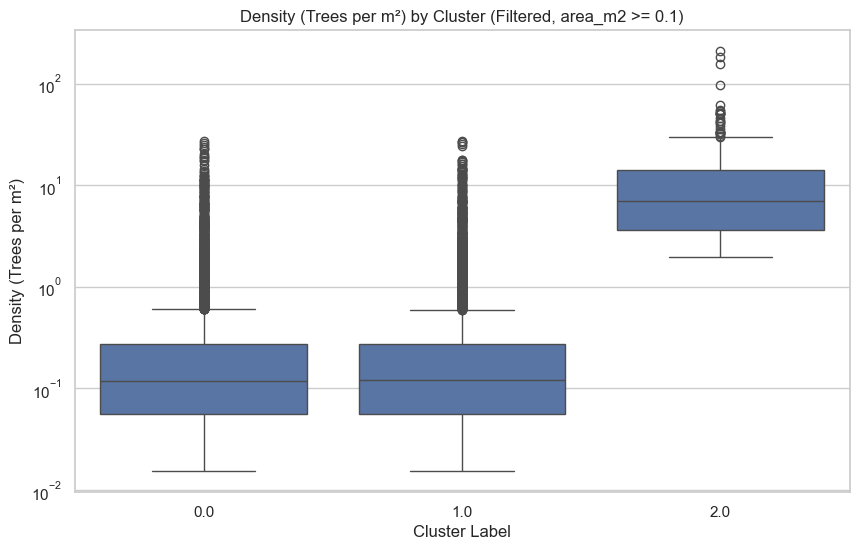


Spearman Correlation of Density with Spatial Metrics  (Filtered, area_m2 >= 0.1):
                      density   area_m2  compactness  aspect_ratio_capped
density              1.000000 -0.999386    -0.459865             0.434950
area_m2             -0.999386  1.000000     0.470420            -0.444379
compactness         -0.459865  0.470420     1.000000            -0.989783
aspect_ratio_capped  0.434950 -0.444379    -0.989783             1.000000


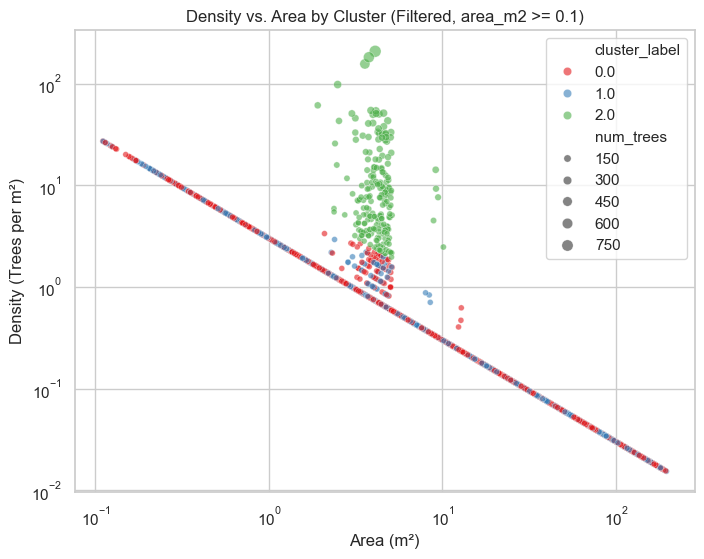

In [63]:
df_filtered = df_combined[df_combined['area_m2'] >= 0.1].copy()
density_summary_filtered = df_filtered.groupby('cluster_label').agg({
    'density': ['mean', 'median', 'std', 'min', 'max'],
    'num_trees': ['mean'],
    'area_m2': ['mean']
})
density_summary_filtered.columns = ['density_mean', 'density_median', 'density_std', 'density_min', 'density_max', 
                                    'num_trees_mean', 'area_m2_mean']
print("\nCluster Density Summary (Filtered, area_m2 >= 0.1):")
print(density_summary_filtered)

# 10. Visualize density across clusters
plt.figure(figsize=(10, 6))
sns.boxplot(x='cluster_label', y='density', data=df_filtered)
plt.title('Density (Trees per m²) by Cluster (Filtered, area_m2 >= 0.1)')
plt.xlabel('Cluster Label')
plt.ylabel('Density (Trees per m²)')
plt.yscale('log')  # Log scale due to skewness in density
plt.show()

# 11. Correlate density with spatial metrics
corr_metrics = ['density', 'area_m2', 'compactness', 'aspect_ratio_capped']
spearman_corr = df_filtered[corr_metrics].corr(method='spearman')
print("\nSpearman Correlation of Density with Spatial Metrics  (Filtered, area_m2 >= 0.1):")
print(spearman_corr)

# 12. Visualize density vs. area_m2
plt.figure(figsize=(8, 6))
sns.scatterplot(x='area_m2', y='density', hue='cluster_label', size='num_trees', 
                data=df_filtered, palette='Set1', alpha=0.6)
plt.title('Density vs. Area by Cluster (Filtered, area_m2 >= 0.1)')
plt.xlabel('Area (m²)')
plt.ylabel('Density (Trees per m²)')
plt.xscale('log')
plt.yscale('log')
plt.show()


Cluster Density Summary (Filtered, area_m2 >= 0.1 and density <= 100):
               density_mean  density_median  density_std  density_min  \
cluster_label                                                           
0.0                0.429221        0.117805     2.169130     0.015475   
1.0                0.406998        0.119879     1.728202     0.015318   
2.0               12.112867        6.749467    13.997213     1.963632   

               density_max  num_trees_mean  area_m2_mean  
cluster_label                                             
0.0              90.069534        3.023313     38.357100  
1.0              57.232293        3.018025     37.497315  
2.0              97.923038       49.476190      4.278995  

Cluster Sizes (Filtered):
cluster_label
0.0    9823
1.0    8322
2.0     210
Name: count, dtype: int64


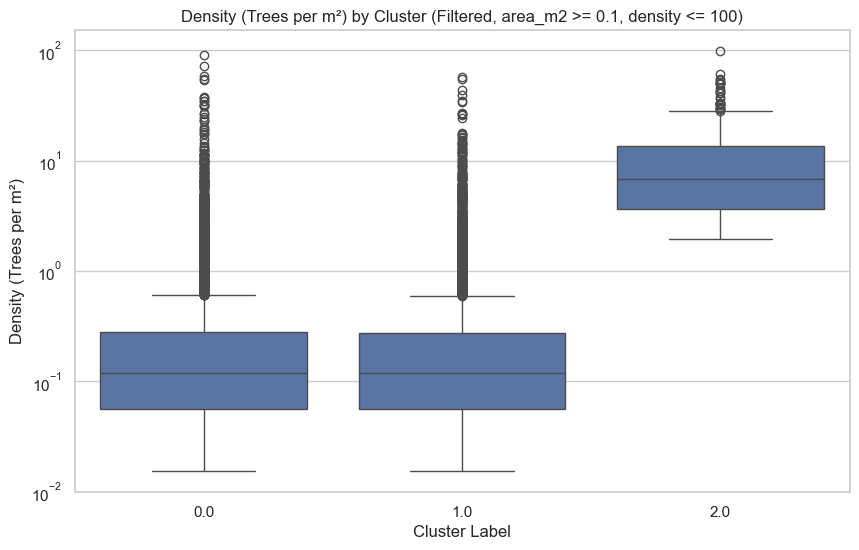

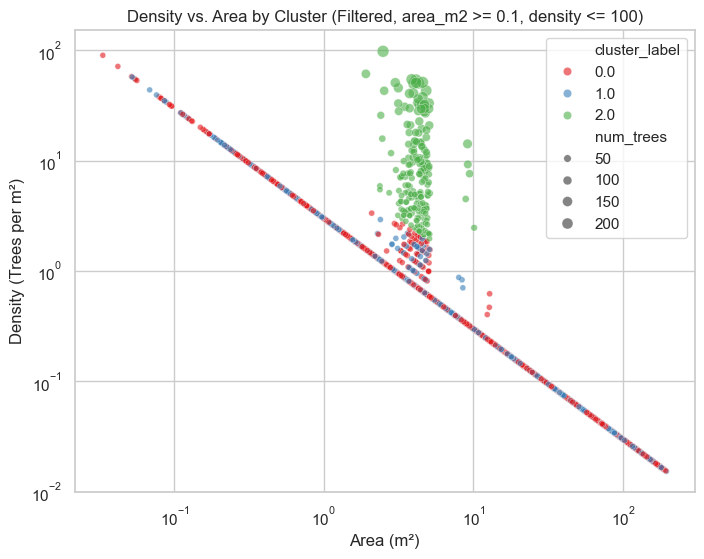

In [65]:
# Filter clusters with density <= 100 trees/m²
df_filtered_density = df_combined[df_combined['density'] <= 100].copy()

# Recompute the density summary
density_summary_filtered_density = df_filtered_density.groupby('cluster_label').agg({
    'density': ['mean', 'median', 'std', 'min', 'max'],
    'num_trees': ['mean'],
    'area_m2': ['mean']
})
density_summary_filtered_density.columns = ['density_mean', 'density_median', 'density_std', 'density_min', 'density_max', 
                                            'num_trees_mean', 'area_m2_mean']
print("\nCluster Density Summary (Filtered, area_m2 >= 0.1 and density <= 100):")
print(density_summary_filtered_density)

# Recompute cluster sizes after filtering
print("\nCluster Sizes (Filtered):")
print(df_filtered_density['cluster_label'].value_counts())

# Recompute visualizations
plt.figure(figsize=(10, 6))
sns.boxplot(x='cluster_label', y='density', data=df_filtered_density)
plt.title('Density (Trees per m²) by Cluster (Filtered, area_m2 >= 0.1, density <= 100)')
plt.xlabel('Cluster Label')
plt.ylabel('Density (Trees per m²)')
plt.yscale('log')
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(x='area_m2', y='density', hue='cluster_label', size='num_trees', 
                data=df_filtered_density, palette='Set1', alpha=0.6)
plt.title('Density vs. Area by Cluster (Filtered, area_m2 >= 0.1, density <= 100)')
plt.xlabel('Area (m²)')
plt.ylabel('Density (Trees per m²)')
plt.xscale('log')
plt.yscale('log')
plt.show()

In [73]:
import pandas as pd
import numpy as np

# Compute cluster counts
cluster_counts = df_filtered_density['cluster_label'].value_counts()
total_clusters = len(df_filtered_density)

# Ensure cluster labels are consistent
df_filtered_density['cluster_label'] = df_filtered_density['cluster_label'].astype(str)
cluster_counts.index = cluster_counts.index.astype(str)

# Compute weights to give each cluster equal total influence
num_clusters = len(cluster_counts)  # 3 clusters
weights = total_clusters / (num_clusters * cluster_counts)  # Equal total weight per cluster
weights = weights / weights.sum() * len(weights)  # Normalize

# Map weights to the DataFrame
df_filtered_density['weight'] = df_filtered_density['cluster_label'].map(weights)

# Handle NaNs if any
if df_filtered_density['weight'].isna().any():
    mean_weight = df_filtered_density['weight'].mean()
    df_filtered_density['weight'].fillna(mean_weight, inplace=True)

# Weighted Spearman correlation function
def weighted_spearman(x, y, weights):
    weights = weights / weights.sum()
    x_rank = pd.Series(x).rank()
    y_rank = pd.Series(y).rank()
    mean_x_rank = np.average(x_rank, weights=weights)
    mean_y_rank = np.average(y_rank, weights=weights)
    cov_xy = np.average((x_rank - mean_x_rank) * (y_rank - mean_y_rank), weights=weights)
    var_x = np.average((x_rank - mean_x_rank)**2, weights=weights)
    var_y = np.average((y_rank - mean_y_rank)**2, weights=weights)
    if var_x * var_y == 0:
        return np.nan
    return cov_xy / np.sqrt(var_x * var_y)

# Compute weighted correlations
corr_metrics = ['density', 'area_m2', 'compactness', 'aspect_ratio_capped']
weighted_spearman_corr = pd.DataFrame(index=corr_metrics, columns=corr_metrics)
for i in corr_metrics:
    for j in corr_metrics:
        if i == j:
            weighted_spearman_corr.loc[i, j] = 1.0
        else:
            weighted_spearman_corr.loc[i, j] = weighted_spearman(
                df_filtered_density[i], df_filtered_density[j], df_filtered_density['weight']
            )

# Print the result
print("\nFinal Adjusted Weighted Spearman Correlation of Density with Spatial Metrics (Filtered, area_m2 >= 0.1, density <= 100):")
print(weighted_spearman_corr)

# Optional: Compute Spearman correlation within Cluster 2.0 (if needed)
cluster_2 = df_filtered_density[df_filtered_density['cluster_label'] == '2.0']
spearman_corr_cluster_2 = cluster_2[corr_metrics].corr(method='spearman')
print("\nSpearman Correlation within Cluster 2.0 (Filtered, area_m2 >= 0.1, density <= 100):")
print(spearman_corr_cluster_2)


Final Adjusted Weighted Spearman Correlation of Density with Spatial Metrics (Filtered, area_m2 >= 0.1, density <= 100):
                      density   area_m2 compactness aspect_ratio_capped
density                   1.0 -0.995487    0.091035           -0.089936
area_m2             -0.995487       1.0   -0.025853            0.028246
compactness          0.091035 -0.025853         1.0           -0.991107
aspect_ratio_capped -0.089936  0.028246   -0.991107                 1.0

Spearman Correlation within Cluster 2.0 (Filtered, area_m2 >= 0.1, density <= 100):
                      density   area_m2  compactness  aspect_ratio_capped
density              1.000000 -0.108063    -0.053707             0.087789
area_m2             -0.108063  1.000000     0.596097            -0.366575
compactness         -0.053707  0.596097     1.000000            -0.599496
aspect_ratio_capped  0.087789 -0.366575    -0.599496             1.000000


Columns in df_spatial (from gdf): ['x', 'y', 'index']
Columns in df_filtered_density: ['area_m2', 'perimeter_m', 'compactness', 'aspect_ratio_capped', 'num_trees', 'log_aspect_ratio_capped', 'log_num_trees', 'cluster_label', 'density', 'weight', 'index']

Merged DataFrame Shape: (18568, 13)
Columns in df_analysis: ['x', 'y', 'index', 'area_m2', 'perimeter_m', 'compactness', 'aspect_ratio_capped', 'num_trees', 'log_aspect_ratio_capped', 'log_num_trees', 'cluster_label', 'density', 'weight']


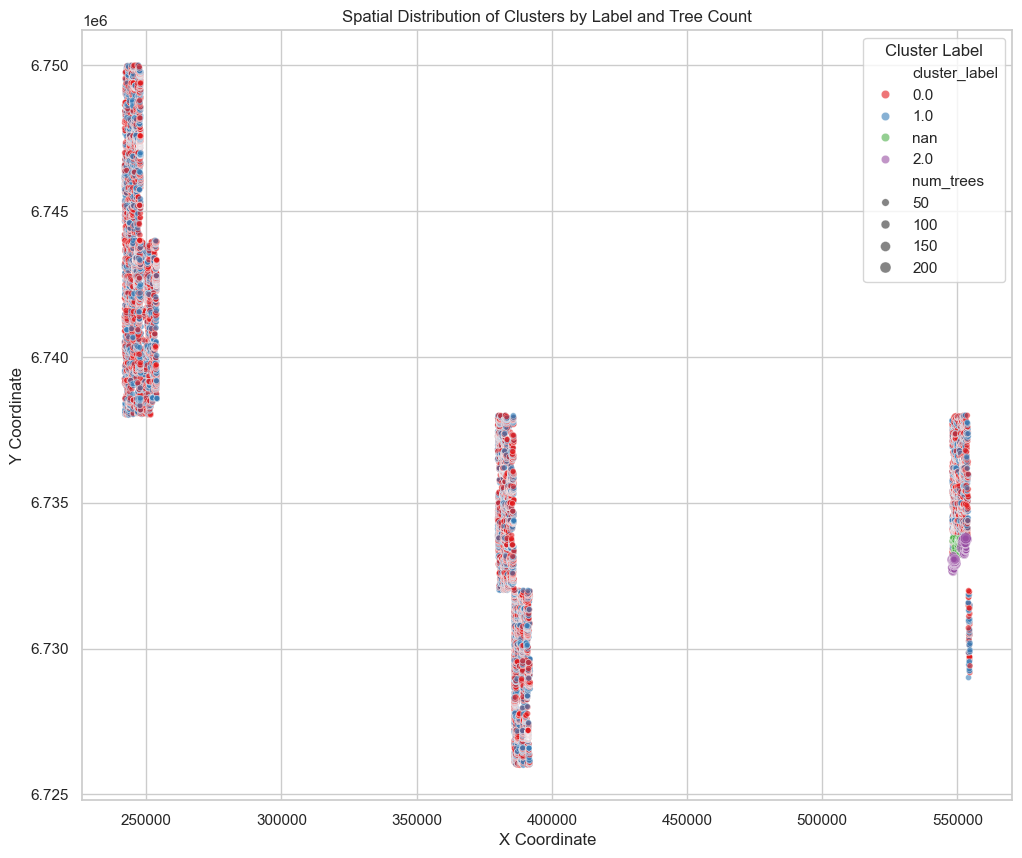


Moran's I for Density:
Moran's I: 0.102
p-value: 0.001
Interpretation: Significant spatial autocorrelation


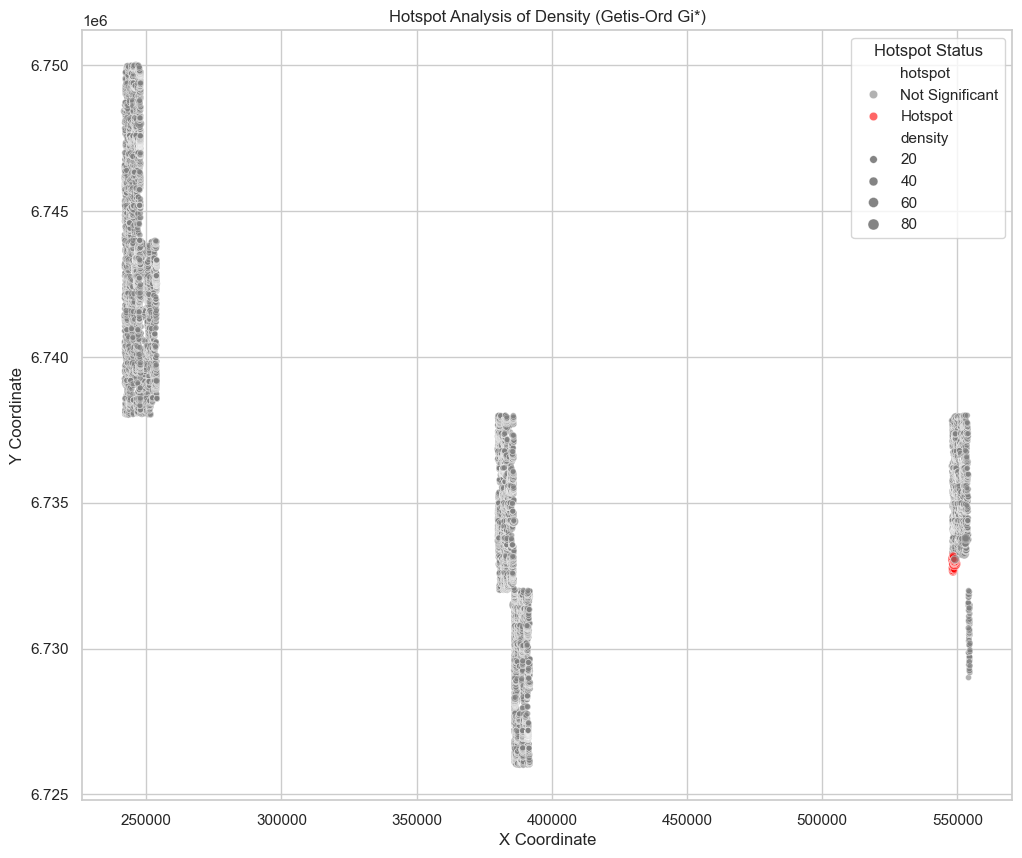


Hotspot Summary by Cluster:
hotspot        Hotspot  Not Significant
cluster_label                          
0.0                  6             9817
1.0                  5             8317
2.0                142               68
nan                  0              213

Mean Aspect Ratio and Compactness by Cluster and Hotspot Status:
              aspect_ratio_capped                 compactness                
hotspot                   Hotspot Not Significant     Hotspot Not Significant
cluster_label                                                                
0.0                      5.640970        6.793929    0.337123        0.311625
1.0                      8.031780        6.858187    0.307882        0.310340
2.0                      1.401137        1.425700    0.574817        0.578981
nan                      0.000000        7.276024    0.000000        0.303785


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from libpysal.weights import DistanceBand
from esda.moran import Moran
from esda.getisord import G_Local

# Step 1: Create DataFrame from gdf with spatial coordinates
df_spatial = pd.DataFrame(gdf[['x', 'y']].copy())

# Add a unique identifier (using index as a key for merging)
df_spatial['index'] = df_spatial.index
df_filtered_density['index'] = df_filtered_density.index

# Print columns to verify
print("Columns in df_spatial (from gdf):", df_spatial.columns.tolist())
print("Columns in df_filtered_density:", df_filtered_density.columns.tolist())

# Step 2: Merge spatial coordinates with filtered data
df_analysis = df_spatial.merge(df_filtered_density, on='index', how='inner', 
                              suffixes=('_gdf', '_filtered'))

# Verify the merge
print("\nMerged DataFrame Shape:", df_analysis.shape)
print("Columns in df_analysis:", df_analysis.columns.tolist())

# Check if 'density' is present; compute if necessary
if 'density' not in df_analysis.columns:
    if 'num_trees' in df_analysis.columns and 'area_m2' in df_analysis.columns:
        print("Computing 'density' as num_trees / area_m2")
        df_analysis['density'] = df_analysis['num_trees'] / df_analysis['area_m2']
    else:
        raise ValueError("Cannot compute 'density': 'num_trees' or 'area_m2' missing in df_analysis")

# Step 3: Visualize spatial distribution
plt.figure(figsize=(12, 10))
sns.scatterplot(x='x', y='y', hue='cluster_label', size='num_trees', 
                data=df_analysis, palette='Set1', alpha=0.6)
plt.title('Spatial Distribution of Clusters by Label and Tree Count')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend(title='Cluster Label')
plt.show()

# Step 4: Spatial autocorrelation (Moran's I for density)
coords = df_analysis[['x', 'y']].values
w = DistanceBand.from_array(coords, threshold=1000)  # Adjust threshold based on your data's scale
w.transform = 'r'

moran = Moran(df_analysis['density'], w)
print("\nMoran's I for Density:")
print(f"Moran's I: {moran.I:.3f}")
print(f"p-value: {moran.p_sim:.3f}")
print(f"Interpretation: {'Significant spatial autocorrelation' if moran.p_sim < 0.05 else 'No significant spatial autocorrelation'}")

# Step 5: Hotspot analysis (Getis-Ord Gi* for density)
gi = G_Local(df_analysis['density'], w)
df_analysis['gi_z'] = gi.Zs
df_analysis['gi_p'] = gi.p_sim

df_analysis['hotspot'] = 'Not Significant'
df_analysis.loc[(df_analysis['gi_z'] > 1.96) & (df_analysis['gi_p'] < 0.05), 'hotspot'] = 'Hotspot'
df_analysis.loc[(df_analysis['gi_z'] < -1.96) & (df_analysis['gi_p'] < 0.05), 'hotspot'] = 'Coldspot'

# Visualize hotspots
plt.figure(figsize=(12, 10))
sns.scatterplot(x='x', y='y', hue='hotspot', size='density', 
                data=df_analysis, palette={'Hotspot': 'red', 'Coldspot': 'blue', 'Not Significant': 'grey'}, 
                alpha=0.6)
plt.title('Hotspot Analysis of Density (Getis-Ord Gi*)')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend(title='Hotspot Status')
plt.show()

# Step 6: Summarize hotspots by cluster
print("\nHotspot Summary by Cluster:")
print(df_analysis.groupby(['cluster_label', 'hotspot']).size().unstack(fill_value=0))

# Step 7: Analyze aspect ratio and compactness by spatial pattern
print("\nMean Aspect Ratio and Compactness by Cluster and Hotspot Status:")
print(df_analysis.groupby(['cluster_label', 'hotspot'])[['aspect_ratio_capped', 'compactness']].mean().unstack(fill_value=0))


Explained Variance Ratio for Each Principal Component:
PC1: 0.439 (43.9%)
PC2: 0.338 (33.8%)
PC3: 0.131 (13.1%)
PC4: 0.062 (6.2%)
PC5: 0.031 (3.1%)

Cumulative Explained Variance:
PC1 to PC1: 0.439 (43.9%)
PC1 to PC2: 0.777 (77.7%)
PC1 to PC3: 0.908 (90.8%)
PC1 to PC4: 0.969 (96.9%)
PC1 to PC5: 1.000 (100.0%)


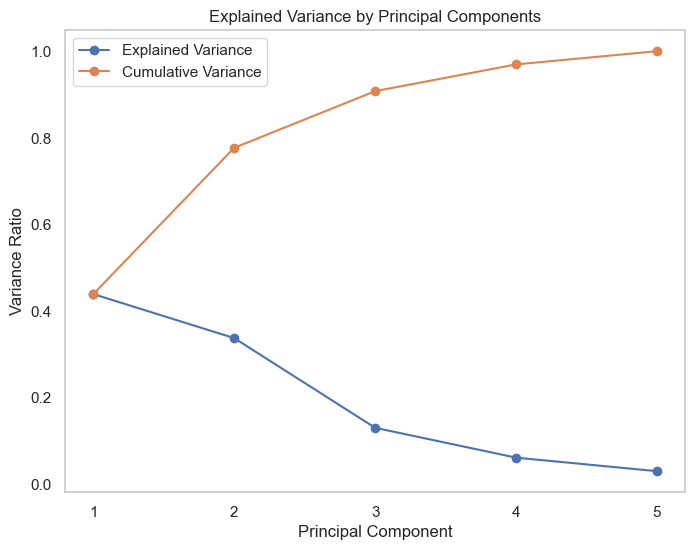

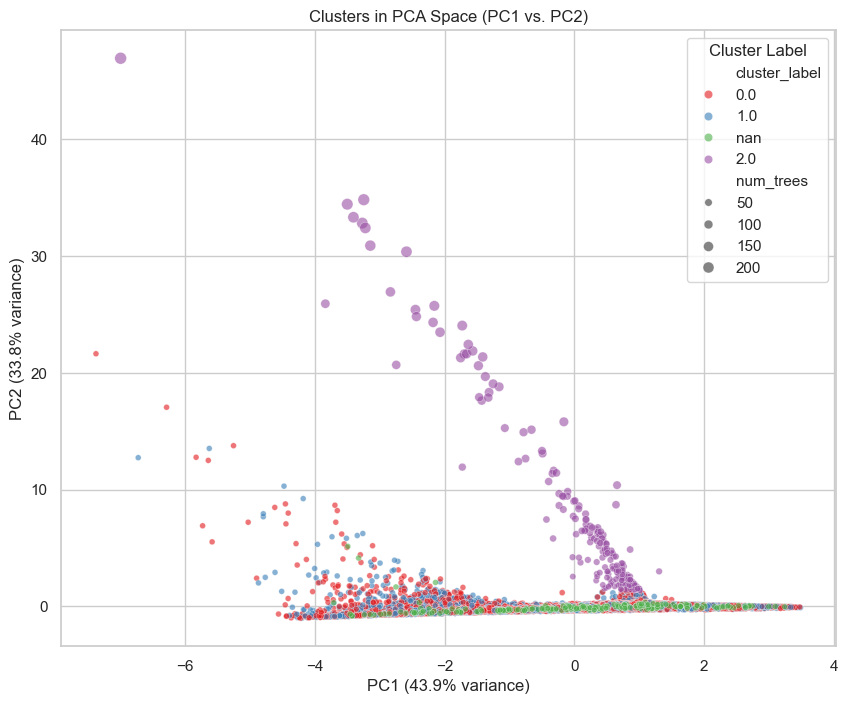


Feature Loadings (Contributions to Principal Components):
                          PC1       PC2       PC3       PC4       PC5
density             -0.173543  0.676356  0.123103  0.695836  0.114385
area_m2              0.473407 -0.058252  0.875560  0.031306 -0.070051
compactness          0.617105  0.147816 -0.263696 -0.062107  0.723836
aspect_ratio_capped -0.602995 -0.132144  0.377230 -0.197431  0.661554
num_trees           -0.036700  0.706992  0.080013 -0.687020 -0.142887

Correlation of Original Features with Principal Components:
                          PC1       PC2       PC3       PC4       PC5
density             -0.257206  0.878880  0.099517  0.386740  0.044705
area_m2              0.701628 -0.075695  0.707807  0.017400 -0.027378
compactness          0.914601  0.192078 -0.213173 -0.034518  0.282898
aspect_ratio_capped -0.893689 -0.171712  0.304954 -0.109731  0.258556
num_trees           -0.054392  0.918690  0.064683 -0.381840 -0.055845


In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Step 1: Prepare the data for PCA
features = ['density', 'area_m2', 'compactness', 'aspect_ratio_capped', 'num_trees']
X = df_filtered_density[features]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 2: Run PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Print explained variance
print("\nExplained Variance Ratio for Each Principal Component:")
for i, var in enumerate(explained_variance_ratio):
    print(f"PC{i+1}: {var:.3f} ({var*100:.1f}%)")
print("\nCumulative Explained Variance:")
for i, cum_var in enumerate(cumulative_variance):
    print(f"PC1 to PC{i+1}: {cum_var:.3f} ({cum_var*100:.1f}%)")

# Step 3: Visualize explained variance
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', label='Explained Variance')
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', label='Cumulative Variance')
plt.title('Explained Variance by Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Variance Ratio')
plt.xticks(range(1, len(features) + 1))
plt.legend()
plt.grid()
plt.show()

# Step 4: Visualize clusters in PCA space (PC1 vs. PC2)
df_pca = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
df_pca['cluster_label'] = df_filtered_density['cluster_label'].values
df_pca['num_trees'] = df_filtered_density['num_trees'].values  # Ensure num_trees is added to df_pca

plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='cluster_label', size='num_trees', 
                data=df_pca, palette='Set1', alpha=0.6)
plt.title('Clusters in PCA Space (PC1 vs. PC2)')
plt.xlabel(f'PC1 ({explained_variance_ratio[0]*100:.1f}% variance)')
plt.ylabel(f'PC2 ({explained_variance_ratio[1]*100:.1f}% variance)')
plt.legend(title='Cluster Label')
plt.show()

# Step 5: Analyze feature loadings
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])], 
                        index=features)
print("\nFeature Loadings (Contributions to Principal Components):")
print(loadings)

# Step 6: Analyze feature correlations with principal components
correlations = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])], 
                           index=features)
correlations = correlations * np.sqrt(pca.explained_variance_)  # Scale by square root of eigenvalues
print("\nCorrelation of Original Features with Principal Components:")
print(correlations)

In [111]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Step 1: Prepare the data
# Target variable
y = df_filtered_density['density']

# Model 1: Original features as predictors (unchanged)
features_orig = ['area_m2', 'compactness', 'aspect_ratio_capped', 'num_trees']
X_original = df_filtered_density[features_orig]

# Standardize the features for Model 1
scaler_orig = StandardScaler()
X_original_scaled = scaler_orig.fit_transform(X_original)

# Model 2: PCA components as predictors, excluding 'density' from PCA computation
features_pca = ['area_m2', 'compactness', 'aspect_ratio_capped', 'num_trees']  # Exclude 'density'
X_pca_input = df_filtered_density[features_pca]

# Standardize the features for PCA
scaler_pca = StandardScaler()
X_pca_scaled = scaler_pca.fit_transform(X_pca_input)

# Compute PCA without 'density'
pca = PCA()
X_pca = pca.fit_transform(X_pca_scaled)

# Explained variance ratio for reference
explained_variance_ratio = pca.explained_variance_ratio_
print("\nExplained Variance Ratio for PCA (Excluding Density):")
for i, var in enumerate(explained_variance_ratio):
    print(f"PC{i+1}: {var:.3f} ({var*100:.1f}%)")

# Step 2: Split the data into training and testing sets
X_train_orig, X_test_orig, y_train, y_test = train_test_split(X_original_scaled, y, test_size=0.2, random_state=42)
X_train_pca, X_test_pca, _, _ = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Step 3: Build and evaluate Model 1 (Original Features)
model_orig = LinearRegression()
model_orig.fit(X_train_orig, y_train)

y_pred_train_orig = model_orig.predict(X_train_orig)
y_pred_test_orig = model_orig.predict(X_test_orig)

r2_train_orig = r2_score(y_train, y_pred_train_orig)
r2_test_orig = r2_score(y_test, y_pred_test_orig)
mse_train_orig = mean_squared_error(y_train, y_pred_train_orig)
mse_test_orig = mean_squared_error(y_test, y_pred_test_orig)

cv_scores_orig = cross_val_score(model_orig, X_original_scaled, y, cv=5, scoring='r2')
cv_mean_orig = cv_scores_orig.mean()
cv_std_orig = cv_scores_orig.std()

coef_orig = pd.DataFrame(model_orig.coef_, index=features_orig, columns=['Coefficient'])

print("\nModel 1: Linear Regression with Original Features")
print(f"Training R²: {r2_train_orig:.3f}")
print(f"Testing R²: {r2_test_orig:.3f}")
print(f"Training MSE: {mse_train_orig:.3f}")
print(f"Testing MSE: {mse_test_orig:.3f}")
print(f"Cross-Validation R²: {cv_mean_orig:.3f} (± {cv_std_orig:.3f})")
print("\nCoefficients:")
print(coef_orig)

# Step 4: Build and evaluate Model 2 (PCA Components, excluding 'density')
model_pca = LinearRegression()
model_pca.fit(X_train_pca, y_train)

y_pred_train_pca = model_pca.predict(X_train_pca)
y_pred_test_pca = model_pca.predict(X_test_pca)

r2_train_pca = r2_score(y_train, y_pred_train_pca)
r2_test_pca = r2_score(y_test, y_pred_test_pca)
mse_train_pca = mean_squared_error(y_train, y_pred_train_pca)
mse_test_pca = mean_squared_error(y_test, y_pred_test_pca)

cv_scores_pca = cross_val_score(model_pca, X_pca, y, cv=5, scoring='r2')
cv_mean_pca = cv_scores_pca.mean()
cv_std_pca = cv_scores_pca.std()

coef_pca = pd.DataFrame(model_pca.coef_, index=[f'PC{i+1}' for i in range(X_pca.shape[1])], columns=['Coefficient'])

print("\nModel 2: Linear Regression with PCA Components (Excluding Density)")
print(f"Training R²: {r2_train_pca:.3f}")
print(f"Testing R²: {r2_test_pca:.3f}")
print(f"Training MSE: {mse_train_pca:.3f}")
print(f"Testing MSE: {mse_test_pca:.3f}")
print(f"Cross-Validation R²: {cv_mean_pca:.3f} (± {cv_std_pca:.3f})")
print("\nCoefficients:")
print(coef_pca)

# Step 5: Compare models
print("\nModel Comparison:")
print(f"Model 1 (Original Features) - Testing R²: {r2_test_orig:.3f}, MSE: {mse_test_orig:.3f}")
print(f"Model 2 (PCA Components) - Testing R²: {r2_test_pca:.3f}, MSE: {mse_test_pca:.3f}")


Explained Variance Ratio for PCA (Excluding Density):
PC1: 0.543 (54.3%)
PC2: 0.258 (25.8%)
PC3: 0.160 (16.0%)
PC4: 0.039 (3.9%)

Model 1: Linear Regression with Original Features
Training R²: 0.536
Testing R²: 0.324
Training MSE: 3.458
Testing MSE: 5.596
Cross-Validation R²: 0.116 (± 0.101)

Coefficients:
                     Coefficient
area_m2                -0.169785
compactness            -0.484558
aspect_ratio_capped    -0.144187
num_trees               1.908312

Model 2: Linear Regression with PCA Components (Excluding Density)
Training R²: 0.536
Testing R²: 0.324
Training MSE: 3.458
Testing MSE: 5.596
Cross-Validation R²: 0.116 (± 0.101)

Coefficients:
     Coefficient
PC1    -0.170918
PC2     1.833551
PC3     0.498955
PC4    -0.534783

Model Comparison:
Model 1 (Original Features) - Testing R²: 0.324, MSE: 5.596
Model 2 (PCA Components) - Testing R²: 0.324, MSE: 5.596
